# Homework 03: Learning Curves and Training Workflow

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

In this homework, you will use **early stopping** to select the "best" model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance. Test accuracy is reported for reference but is not used for model selection.

> **Note:** Throughout this homework, best always refers to the model selected by early stopping at the epoch of minimum validation loss. Do not report metrics from the final training epoch unless explicitly instructed.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [6]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


In [7]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,min_val_epoch + 1)

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [8]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [9]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This data set is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [10]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [11]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [12]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

2026-02-08 18:39:05.875093: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [13]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.


In [43]:
import inspect
print("build_model signature:", inspect.signature(build_model))
print("\ntrain_and_test signature:", inspect.signature(train_and_test))


build_model signature: (n_inputs, layer_list, n_classes)

train_and_test signature: (model, epochs=500, lr_schedule=0.001, optimizer='Adam', title='Learning Curves', batch_size=64, use_early_stopping=True, patience=10, min_delta=0.0001, callbacks=[], verbose=0, return_history=False)



Problem 1 — Activation: relu



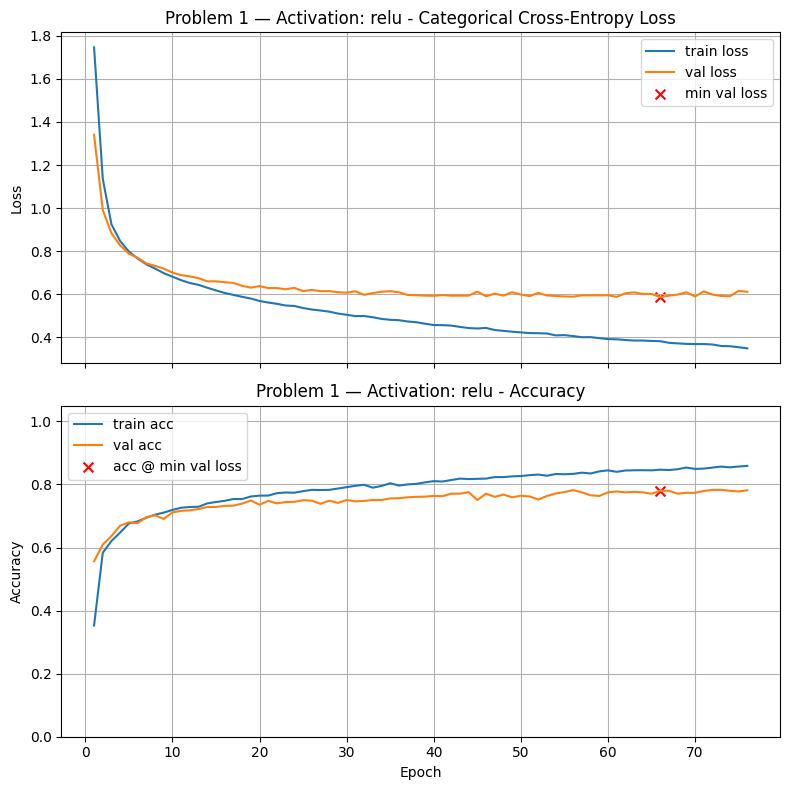

Final Training Loss:            0.3492
Final Training Accuracy:        0.8588
Final Validation Loss:          0.6119
Final Validation Accuracy:      0.7814
Minimum Validation Loss:        0.5870 (Epoch 66)
Validation Accuracy @ Min Loss: 0.7800

Test Loss: 0.5670
Test Accuracy: 0.7800

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:11
Activation=relu    | best_epoch= 65 | best_val_acc=0.780000

Problem 1 — Activation: sigmoid



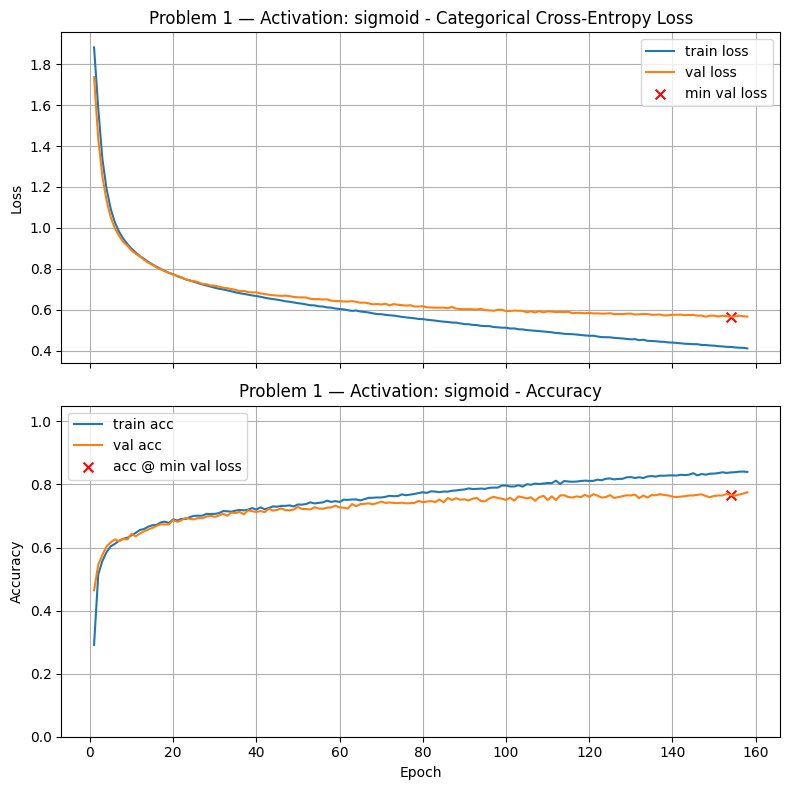

Final Training Loss:            0.4112
Final Training Accuracy:        0.8398
Final Validation Loss:          0.5667
Final Validation Accuracy:      0.7750
Minimum Validation Loss:        0.5660 (Epoch 154)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.5718
Test Accuracy: 0.7714

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:22
Activation=sigmoid | best_epoch=153 | best_val_acc=0.766429

Problem 1 — Activation: tanh



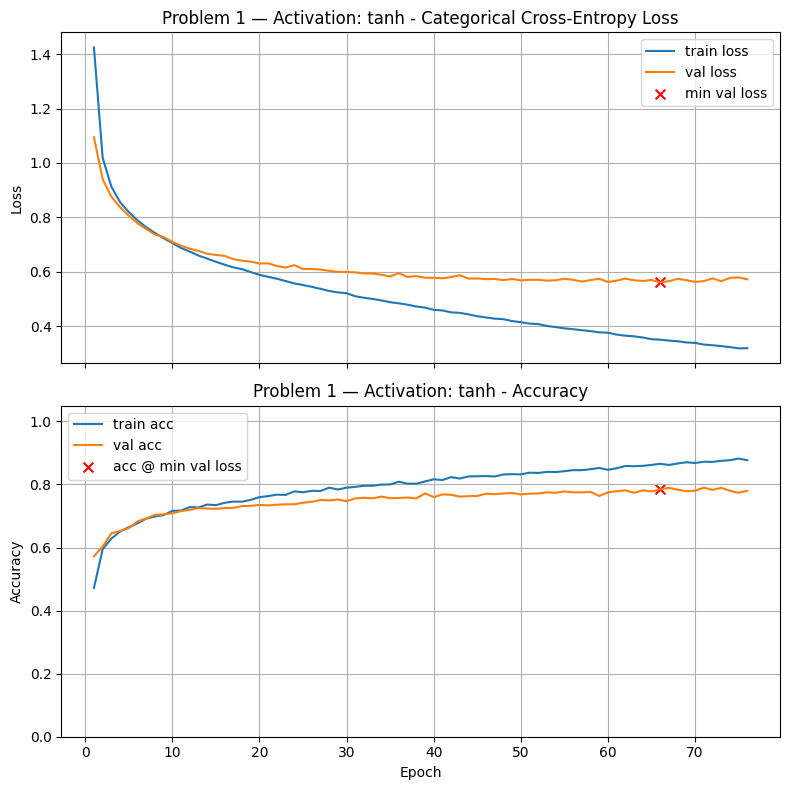

Final Training Loss:            0.3192
Final Training Accuracy:        0.8769
Final Validation Loss:          0.5723
Final Validation Accuracy:      0.7800
Minimum Validation Loss:        0.5606 (Epoch 66)
Validation Accuracy @ Min Loss: 0.7843

Test Loss: 0.5629
Test Accuracy: 0.7707

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:11
Activation=tanh    | best_epoch= 65 | best_val_acc=0.784286

BEST activation: tanh with best_val_acc: 0.7842857241630554


In [50]:
# =========================
# HW03 — Problem 1: Which Activation Function?
# Baseline architecture: input -> 64 -> 32 -> output (softmax)
# Vary hidden activation: relu, sigmoid, tanh
# Early stopping already inside train_and_test; model restores best weights at min val_loss
# =========================

activations = ["relu", "sigmoid", "tanh"]

# infer dimensions from your already-created split
n_inputs  = X_train.shape[1]
n_classes = len(np.unique(y_train))

p1_histories = {}
p1_best_val_acc = {}

for act in activations:
    # baseline: no dropout, no L2 (only activation varies)
    layer_list = [
        (64, act, 0.0, 0.0),
        (32, act, 0.0, 0.0),
    ]

    model_baseline = build_model(n_inputs, layer_list, n_classes)

    # train_and_test uses globals X_train,y_train,X_val,y_val,X_test,y_test
    history = train_and_test(
        model_baseline,
        title=f"Problem 1 — Activation: {act}",
        return_history=True,
        verbose=0
    )

    # best epoch is the one with MIN validation loss (matches early stopping criterion)
    best_epoch = int(np.argmin(history.history["val_loss"]))
    best_val_acc = float(history.history["val_accuracy"][best_epoch])

    p1_histories[act] = history
    p1_best_val_acc[act] = best_val_acc

    print(f"Activation={act:7s} | best_epoch={best_epoch:3d} | best_val_acc={best_val_acc:.6f}")

best_activation = max(p1_best_val_acc, key=p1_best_val_acc.get)
print("\nBEST activation:", best_activation, "with best_val_acc:", p1_best_val_acc[best_activation])


### Graded Questions

In [51]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

act_to_int = {"relu": 0, "sigmoid": 1, "tanh": 2}
a1a = act_to_int[best_activation]


In [52]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 2


In [53]:
# Set a1b to the validation accuracy found by this best activation function

a1b = p1_best_val_acc[best_activation]


In [54]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7843


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**


train_and_test signature: (model, epochs=500, lr_schedule=0.001, optimizer='Adam', title='Learning Curves', batch_size=64, use_early_stopping=True, patience=10, min_delta=0.0001, callbacks=[], verbose=0, return_history=False)

Problem 2 — lr=0.001



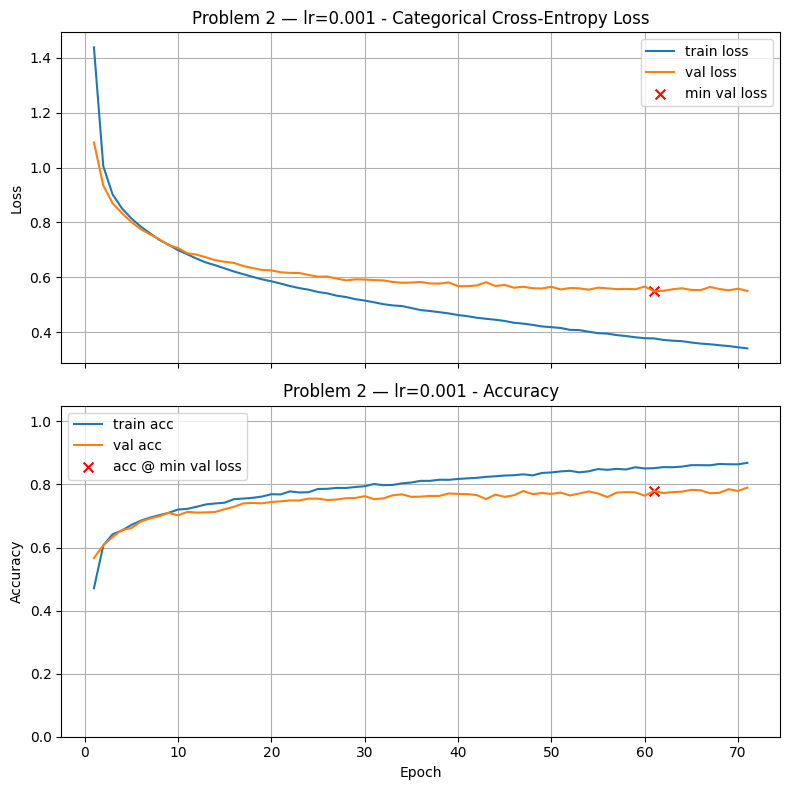

Final Training Loss:            0.3412
Final Training Accuracy:        0.8686
Final Validation Loss:          0.5506
Final Validation Accuracy:      0.7900
Minimum Validation Loss:        0.5491 (Epoch 61)
Validation Accuracy @ Min Loss: 0.7793

Test Loss: 0.5765
Test Accuracy: 0.7664

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:10
lr=  0.001 | best_epoch= 60 | best_val_acc=0.779286

Problem 2 — lr=0.0005



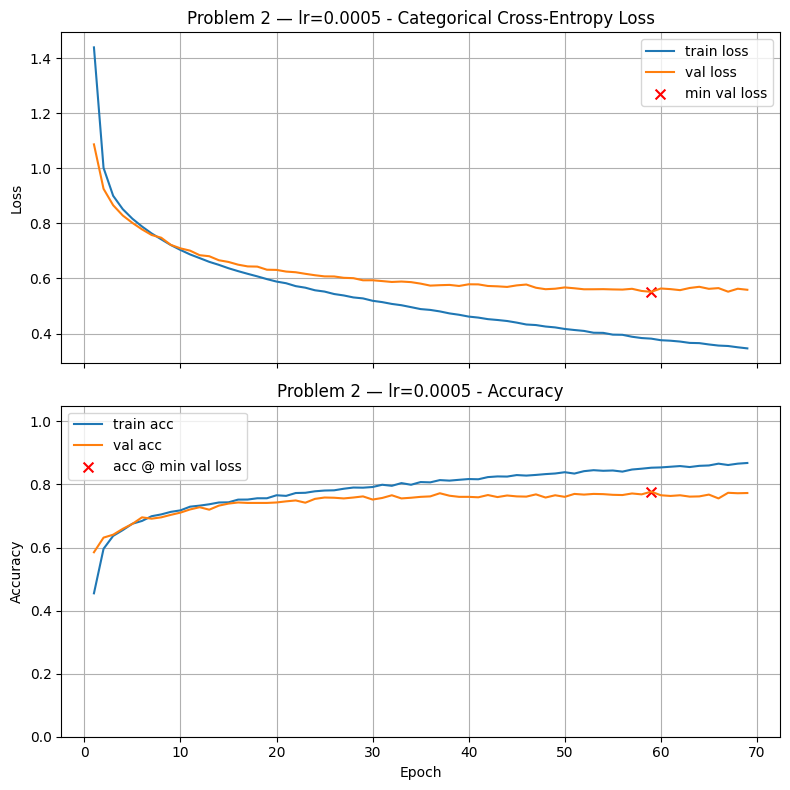

Final Training Loss:            0.3460
Final Training Accuracy:        0.8681
Final Validation Loss:          0.5589
Final Validation Accuracy:      0.7729
Minimum Validation Loss:        0.5514 (Epoch 59)
Validation Accuracy @ Min Loss: 0.7771

Test Loss: 0.5664
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.022857

Execution Time: 00:00:10
lr= 0.0005 | best_epoch= 58 | best_val_acc=0.777143

Problem 2 — lr=0.0001



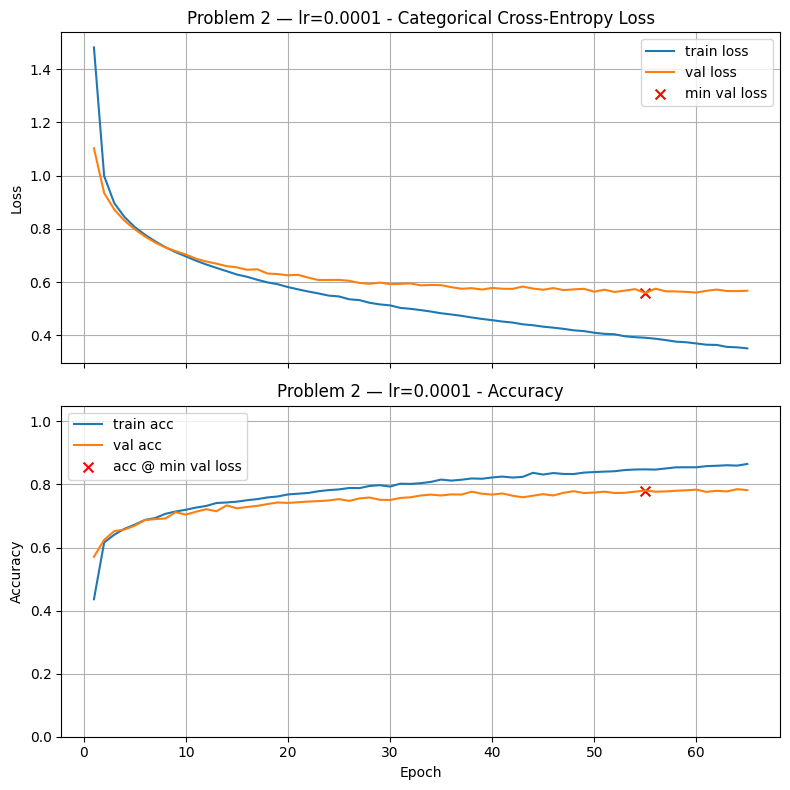

Final Training Loss:            0.3517
Final Training Accuracy:        0.8650
Final Validation Loss:          0.5681
Final Validation Accuracy:      0.7821
Minimum Validation Loss:        0.5594 (Epoch 55)
Validation Accuracy @ Min Loss: 0.7807

Test Loss: 0.5750
Test Accuracy: 0.7636

Validation-Test Gap (accuracy): 0.017143

Execution Time: 00:00:09
lr= 0.0001 | best_epoch= 54 | best_val_acc=0.780714

Problem 2 — lr=5e-05



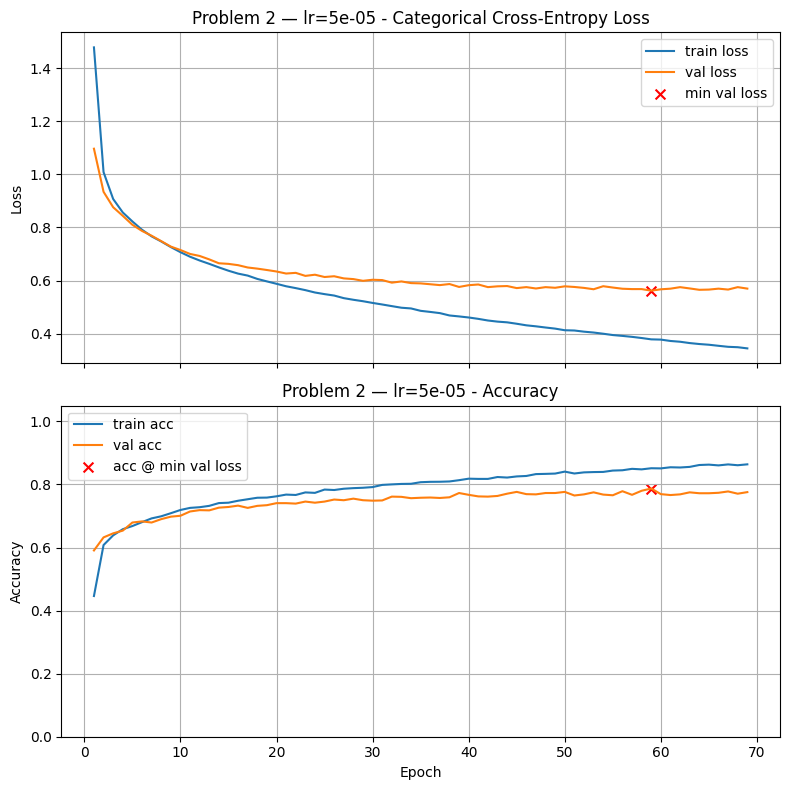

Final Training Loss:            0.3445
Final Training Accuracy:        0.8638
Final Validation Loss:          0.5697
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.5620 (Epoch 59)
Validation Accuracy @ Min Loss: 0.7871

Test Loss: 0.5640
Test Accuracy: 0.7743

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:10
lr=  5e-05 | best_epoch= 58 | best_val_acc=0.787143

Problem 2 — lr=1e-05



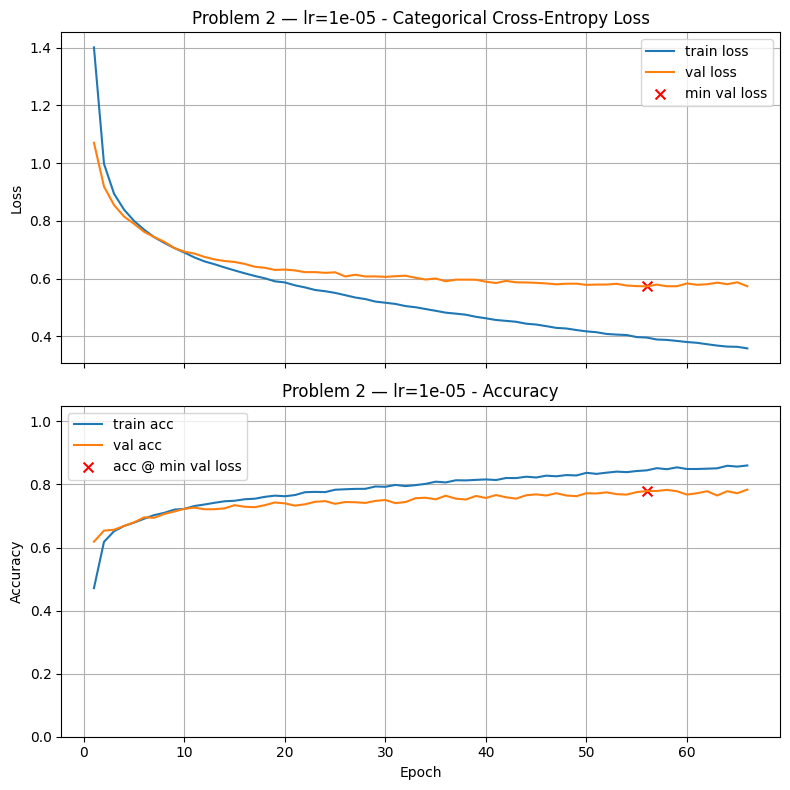

Final Training Loss:            0.3585
Final Training Accuracy:        0.8602
Final Validation Loss:          0.5737
Final Validation Accuracy:      0.7836
Minimum Validation Loss:        0.5732 (Epoch 56)
Validation Accuracy @ Min Loss: 0.7793

Test Loss: 0.5687
Test Accuracy: 0.7650

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:09
lr=  1e-05 | best_epoch= 55 | best_val_acc=0.779286

BEST learning rate: 5e-05 with best_val_acc: 0.7871428728103638


In [56]:
import inspect
import numpy as np
import tensorflow as tf

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

act = best_activation  # from Problem 1

n_inputs  = X_train.shape[1]
n_classes = len(np.unique(y_train))

# See what train_and_test supports (optional, but helpful)
print("train_and_test signature:", inspect.signature(train_and_test))

p2_histories = {}
p2_best_val_acc = {}

for lr in learning_rates:
    layer_list = [
        (64, act, 0.0, 0.0),
        (32, act, 0.0, 0.0),
    ]

    model_lr = build_model(n_inputs, layer_list, n_classes)

    # Compile with the learning rate YOU want
    model_lr.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Call train_and_test WITHOUT lr=...
    # If your train_and_test has an epochs/max_epochs argument, we pass it safely:
    sig = inspect.signature(train_and_test).parameters
    kwargs = {}
    if "max_epochs" in sig:
        kwargs["max_epochs"] = 500
    elif "epochs" in sig:
        kwargs["epochs"] = 500

    # If it supports title/verbose/return_history, pass them too:
    if "title" in sig:
        kwargs["title"] = f"Problem 2 — lr={lr:g}"
    if "verbose" in sig:
        kwargs["verbose"] = 0
    if "return_history" in sig:
        kwargs["return_history"] = True

    out = train_and_test(model_lr, **kwargs)
    history = out[0] if isinstance(out, tuple) else out

    best_epoch = int(np.argmin(history.history["val_loss"]))
    best_val_acc = float(history.history["val_accuracy"][best_epoch])

    p2_histories[lr] = history
    p2_best_val_acc[lr] = best_val_acc

    print(f"lr={lr:7g} | best_epoch={best_epoch:3d} | best_val_acc={best_val_acc:.6f}")

best_lr = max(p2_best_val_acc, key=p2_best_val_acc.get)
print("\nBEST learning rate:", best_lr, "with best_val_acc:", p2_best_val_acc[best_lr])


#### Graded Questions

In [57]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = max(p2_best_val_acc, key=p2_best_val_acc.get)


In [58]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.000050


In [59]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = p2_best_val_acc[a2a]


In [60]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7871


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Learning Curves



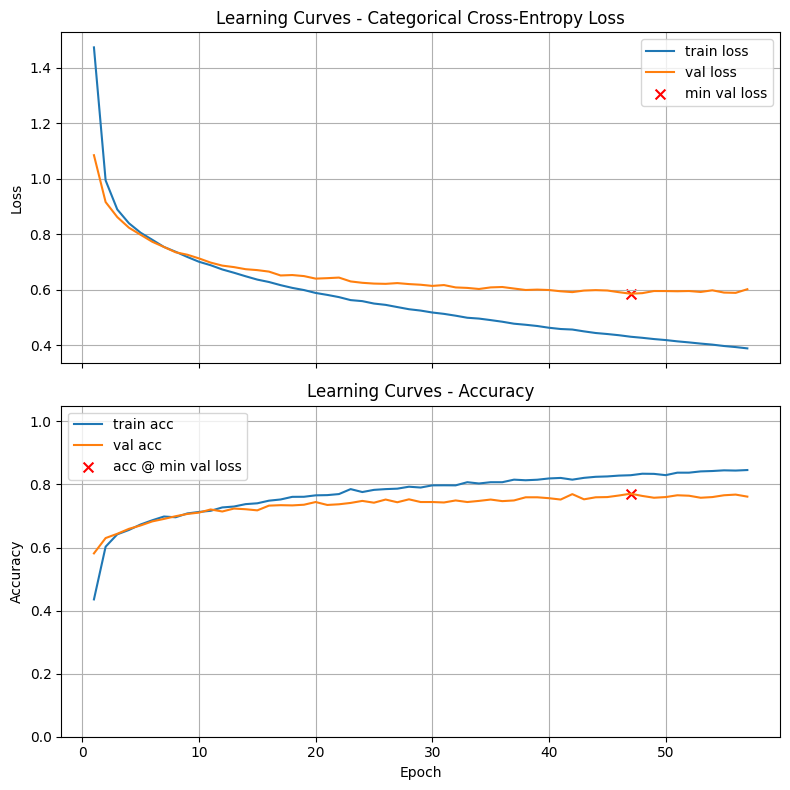

Final Training Loss:            0.3887
Final Training Accuracy:        0.8457
Final Validation Loss:          0.6017
Final Validation Accuracy:      0.7614
Minimum Validation Loss:        0.5855 (Epoch 47)
Validation Accuracy @ Min Loss: 0.7707

Test Loss: 0.5828
Test Accuracy: 0.7514

Validation-Test Gap (accuracy): 0.019286

Execution Time: 00:00:08
drop1=0.0, drop2=0.0 | best_epoch= 46 | best_val_acc=0.770714

Learning Curves



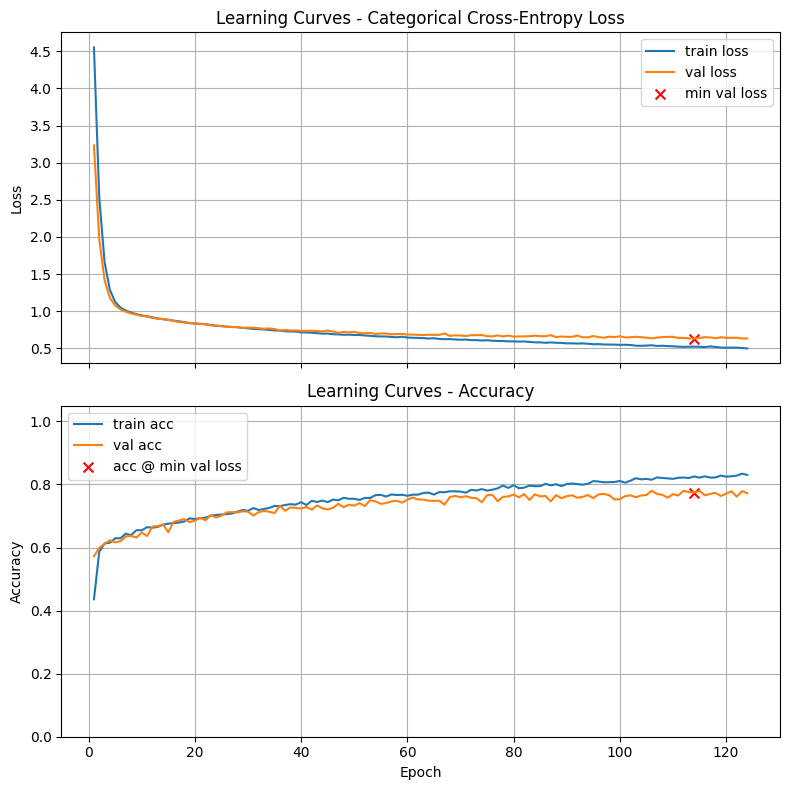

Final Training Loss:            0.4991
Final Training Accuracy:        0.8302
Final Validation Loss:          0.6328
Final Validation Accuracy:      0.7721
Minimum Validation Loss:        0.6319 (Epoch 114)
Validation Accuracy @ Min Loss: 0.7743

Test Loss: 0.6428
Test Accuracy: 0.7600

Validation-Test Gap (accuracy): 0.014286

Execution Time: 00:00:17
drop1=0.0, drop2=0.1 | best_epoch=113 | best_val_acc=0.774286

Learning Curves



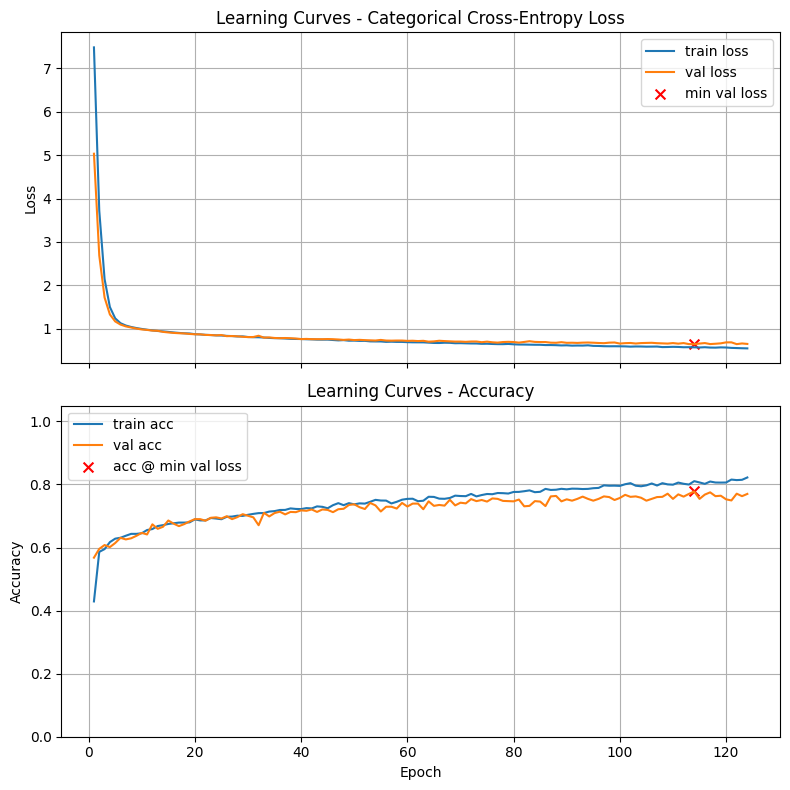

Final Training Loss:            0.5464
Final Training Accuracy:        0.8221
Final Validation Loss:          0.6490
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.6436 (Epoch 114)
Validation Accuracy @ Min Loss: 0.7779

Test Loss: 0.6664
Test Accuracy: 0.7629

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:00:17
drop1=0.0, drop2=0.2 | best_epoch=113 | best_val_acc=0.777857

Learning Curves



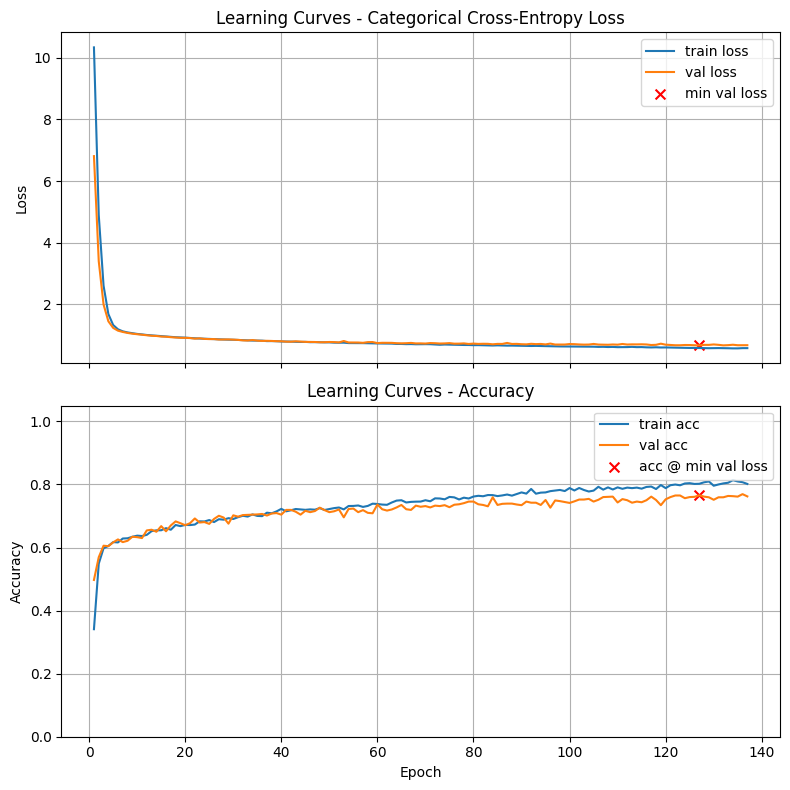

Final Training Loss:            0.5736
Final Training Accuracy:        0.8017
Final Validation Loss:          0.6688
Final Validation Accuracy:      0.7621
Minimum Validation Loss:        0.6638 (Epoch 127)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.6732
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:19
drop1=0.0, drop2=0.3 | best_epoch=126 | best_val_acc=0.765714

Learning Curves



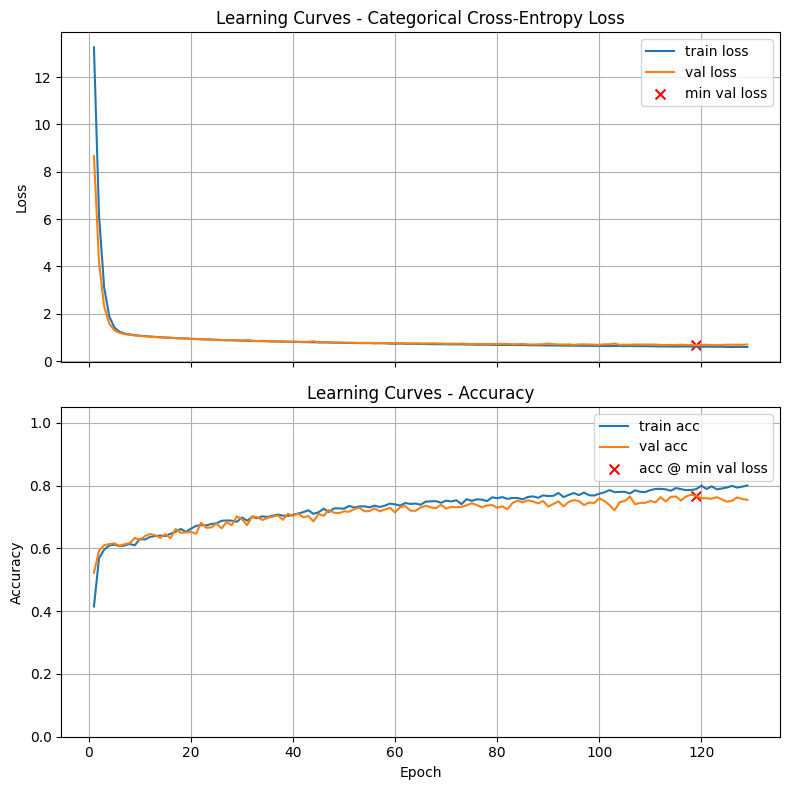

Final Training Loss:            0.5932
Final Training Accuracy:        0.8002
Final Validation Loss:          0.7013
Final Validation Accuracy:      0.7543
Minimum Validation Loss:        0.6704 (Epoch 119)
Validation Accuracy @ Min Loss: 0.7664

Test Loss: 0.6912
Test Accuracy: 0.7379

Validation-Test Gap (accuracy): 0.028571

Execution Time: 00:00:18
drop1=0.0, drop2=0.4 | best_epoch=118 | best_val_acc=0.766429

Learning Curves



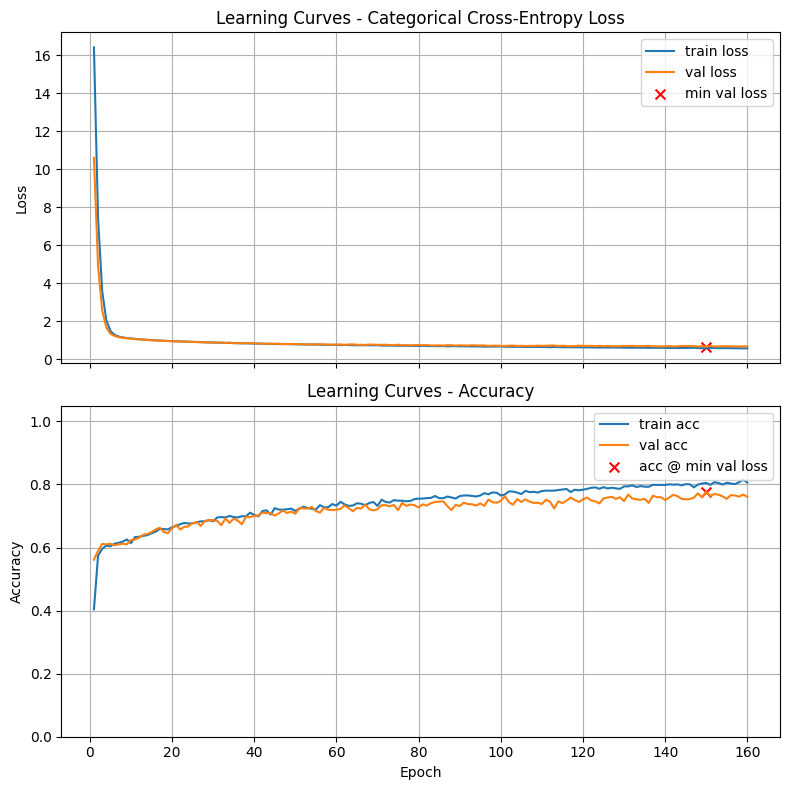

Final Training Loss:            0.5693
Final Training Accuracy:        0.8062
Final Validation Loss:          0.6700
Final Validation Accuracy:      0.7607
Minimum Validation Loss:        0.6587 (Epoch 150)
Validation Accuracy @ Min Loss: 0.7771

Test Loss: 0.6784
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.022143

Execution Time: 00:00:22
drop1=0.0, drop2=0.5 | best_epoch=149 | best_val_acc=0.777143

Learning Curves



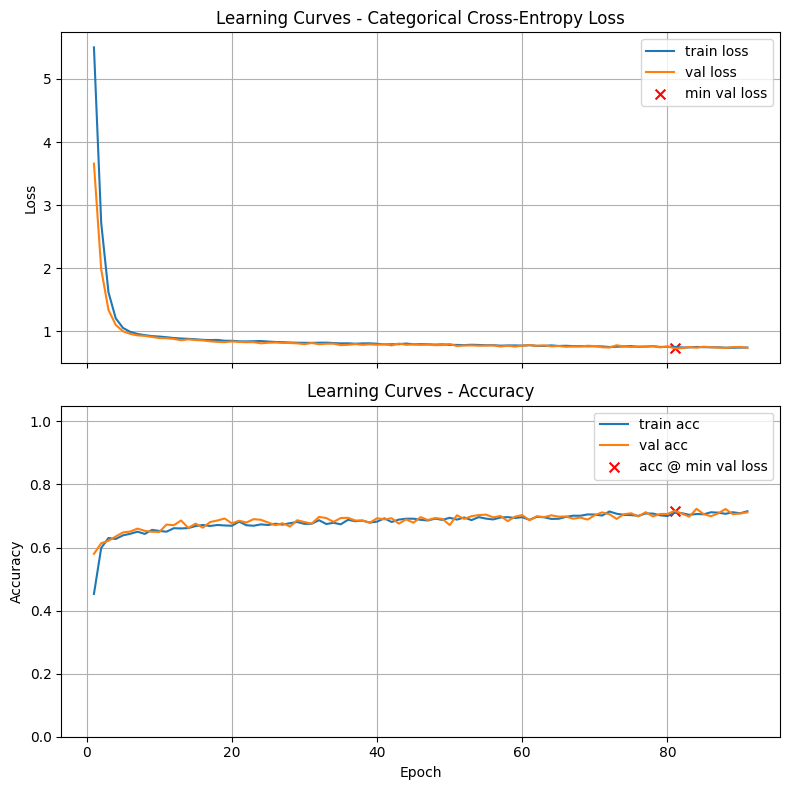

Final Training Loss:            0.7403
Final Training Accuracy:        0.7150
Final Validation Loss:          0.7359
Final Validation Accuracy:      0.7114
Minimum Validation Loss:        0.7272 (Epoch 81)
Validation Accuracy @ Min Loss: 0.7164

Test Loss: 0.7482
Test Accuracy: 0.7193

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:13
drop1=0.1, drop2=0.0 | best_epoch= 80 | best_val_acc=0.716429

Learning Curves



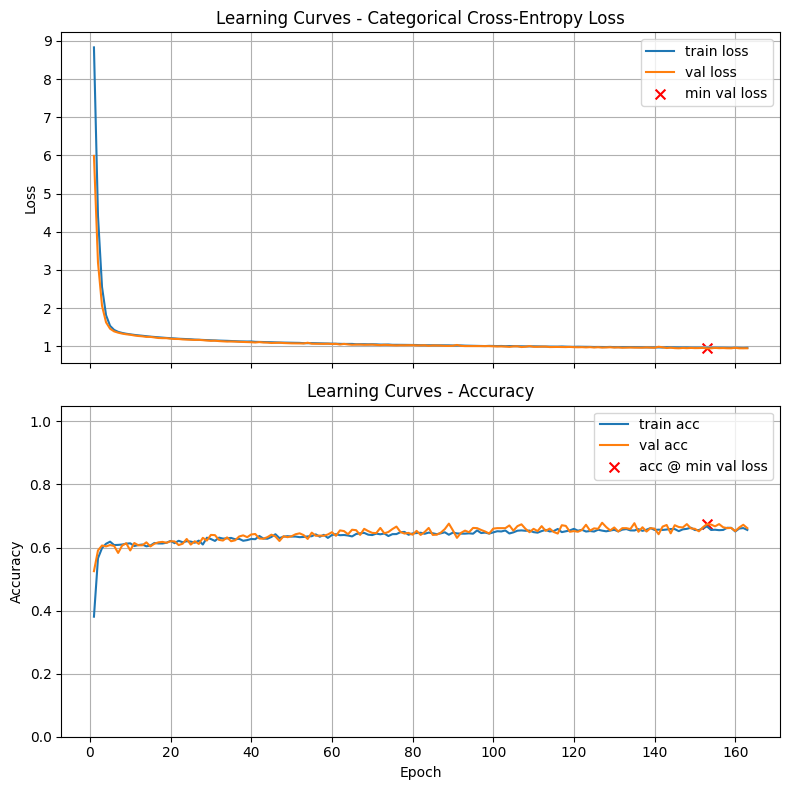

Final Training Loss:            0.9610
Final Training Accuracy:        0.6557
Final Validation Loss:          0.9486
Final Validation Accuracy:      0.6614
Minimum Validation Loss:        0.9457 (Epoch 153)
Validation Accuracy @ Min Loss: 0.6743

Test Loss: 0.9685
Test Accuracy: 0.6764

Validation-Test Gap (accuracy): 0.002143

Execution Time: 00:00:22
drop1=0.1, drop2=0.1 | best_epoch=152 | best_val_acc=0.674286

Learning Curves



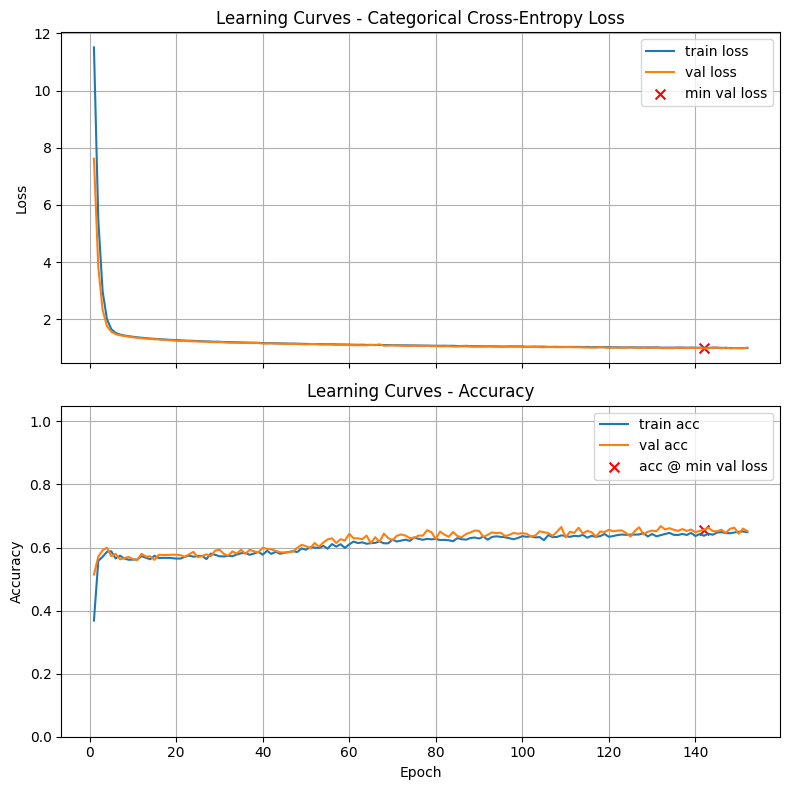

Final Training Loss:            0.9981
Final Training Accuracy:        0.6486
Final Validation Loss:          1.0149
Final Validation Accuracy:      0.6521
Minimum Validation Loss:        0.9883 (Epoch 142)
Validation Accuracy @ Min Loss: 0.6564

Test Loss: 1.0032
Test Accuracy: 0.6457

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:21
drop1=0.1, drop2=0.2 | best_epoch=141 | best_val_acc=0.656429

Learning Curves



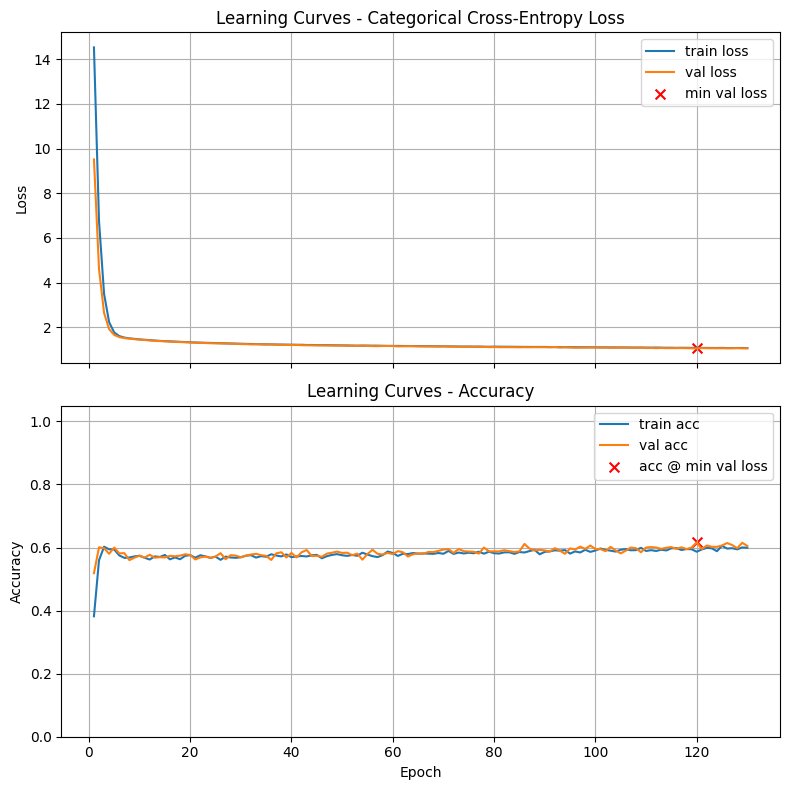

Final Training Loss:            1.0643
Final Training Accuracy:        0.5993
Final Validation Loss:          1.0534
Final Validation Accuracy:      0.6050
Minimum Validation Loss:        1.0518 (Epoch 120)
Validation Accuracy @ Min Loss: 0.6164

Test Loss: 1.0784
Test Accuracy: 0.5971

Validation-Test Gap (accuracy): 0.019286

Execution Time: 00:00:18
drop1=0.1, drop2=0.3 | best_epoch=119 | best_val_acc=0.616429

Learning Curves



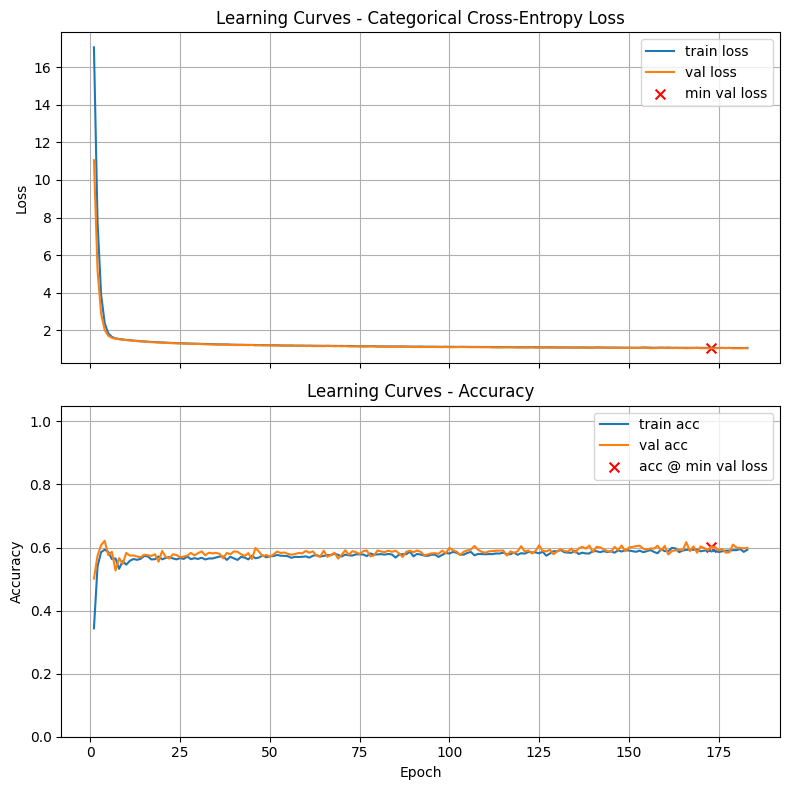

Final Training Loss:            1.0629
Final Training Accuracy:        0.5929
Final Validation Loss:          1.0395
Final Validation Accuracy:      0.5993
Minimum Validation Loss:        1.0383 (Epoch 173)
Validation Accuracy @ Min Loss: 0.6029

Test Loss: 1.0626
Test Accuracy: 0.6000

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:25
drop1=0.1, drop2=0.4 | best_epoch=172 | best_val_acc=0.602857

Learning Curves



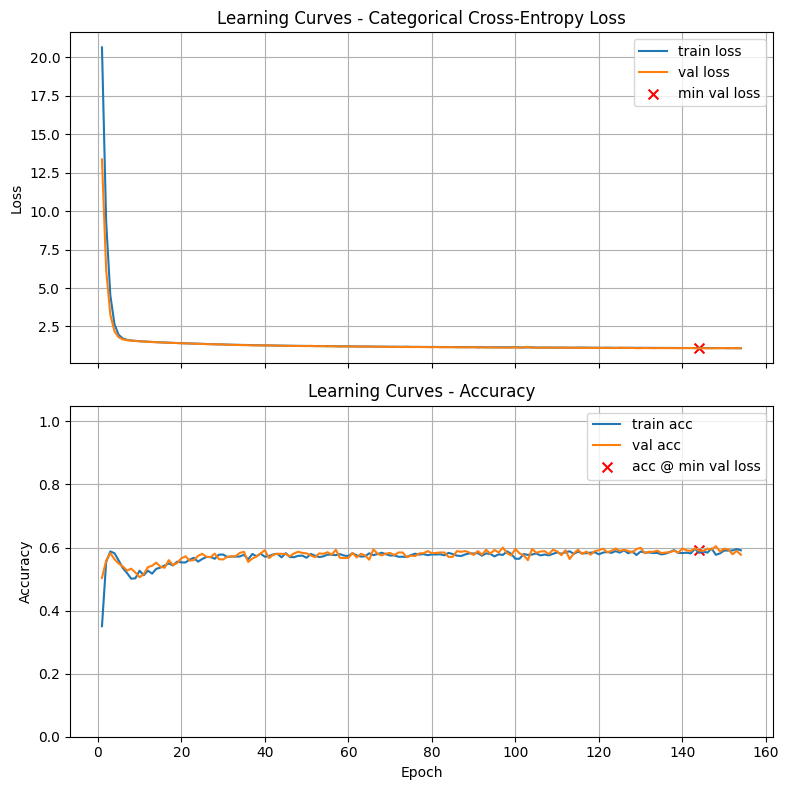

Final Training Loss:            1.0865
Final Training Accuracy:        0.5912
Final Validation Loss:          1.0879
Final Validation Accuracy:      0.5771
Minimum Validation Loss:        1.0756 (Epoch 144)
Validation Accuracy @ Min Loss: 0.5907

Test Loss: 1.0939
Test Accuracy: 0.5900

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:00:21
drop1=0.1, drop2=0.5 | best_epoch=143 | best_val_acc=0.590714

Learning Curves



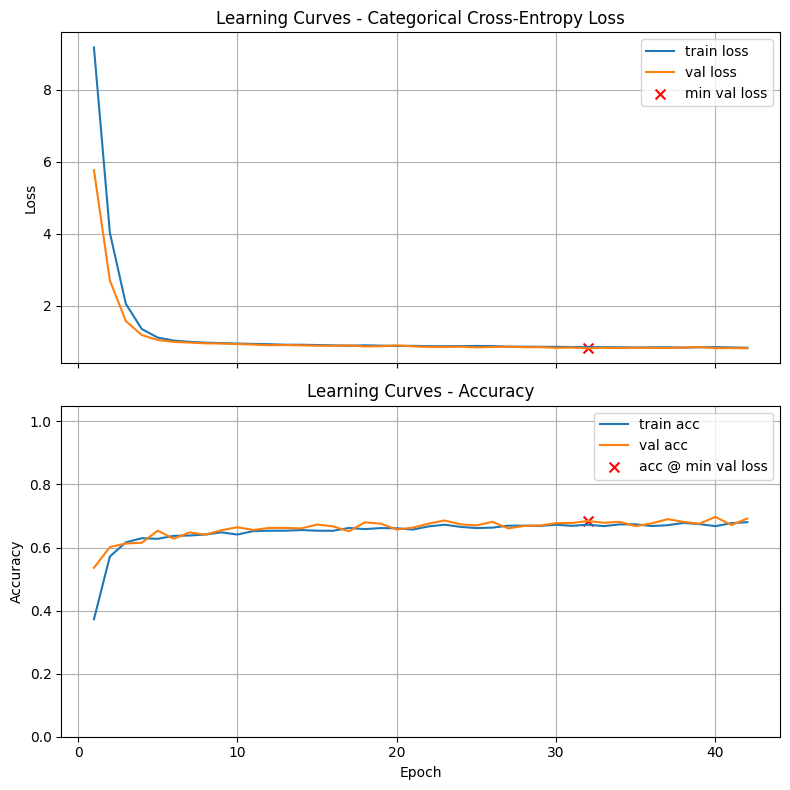

Final Training Loss:            0.8266
Final Training Accuracy:        0.6805
Final Validation Loss:          0.8128
Final Validation Accuracy:      0.6921
Minimum Validation Loss:        0.8105 (Epoch 32)
Validation Accuracy @ Min Loss: 0.6843

Test Loss: 0.8462
Test Accuracy: 0.6686

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:06
drop1=0.2, drop2=0.0 | best_epoch= 31 | best_val_acc=0.684286

Learning Curves



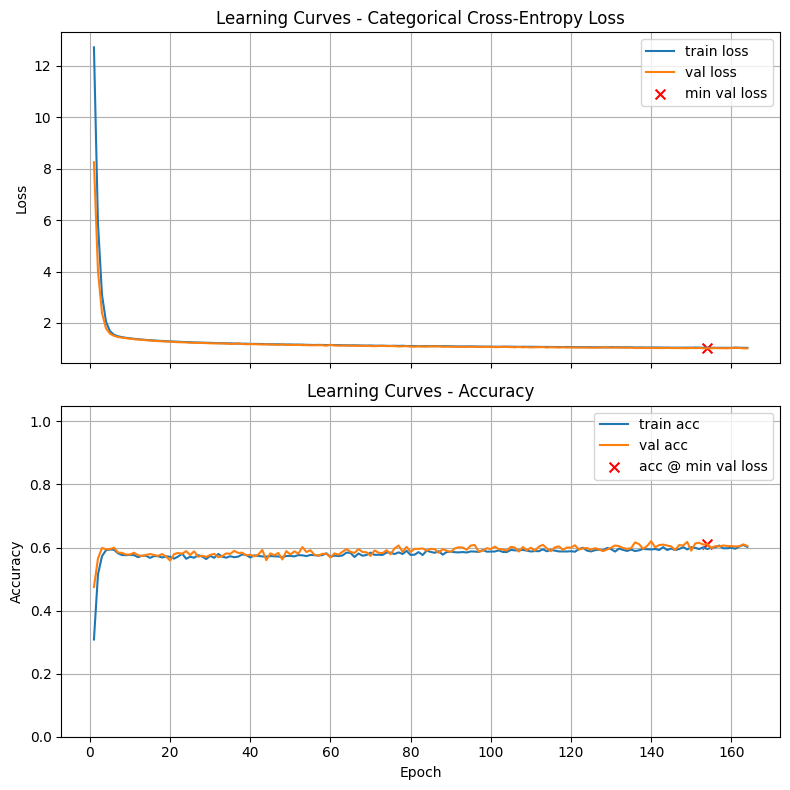

Final Training Loss:            1.0329
Final Training Accuracy:        0.6019
Final Validation Loss:          1.0137
Final Validation Accuracy:      0.6050
Minimum Validation Loss:        1.0131 (Epoch 154)
Validation Accuracy @ Min Loss: 0.6107

Test Loss: 1.0376
Test Accuracy: 0.6114

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:00:22
drop1=0.2, drop2=0.1 | best_epoch=153 | best_val_acc=0.610714

Learning Curves



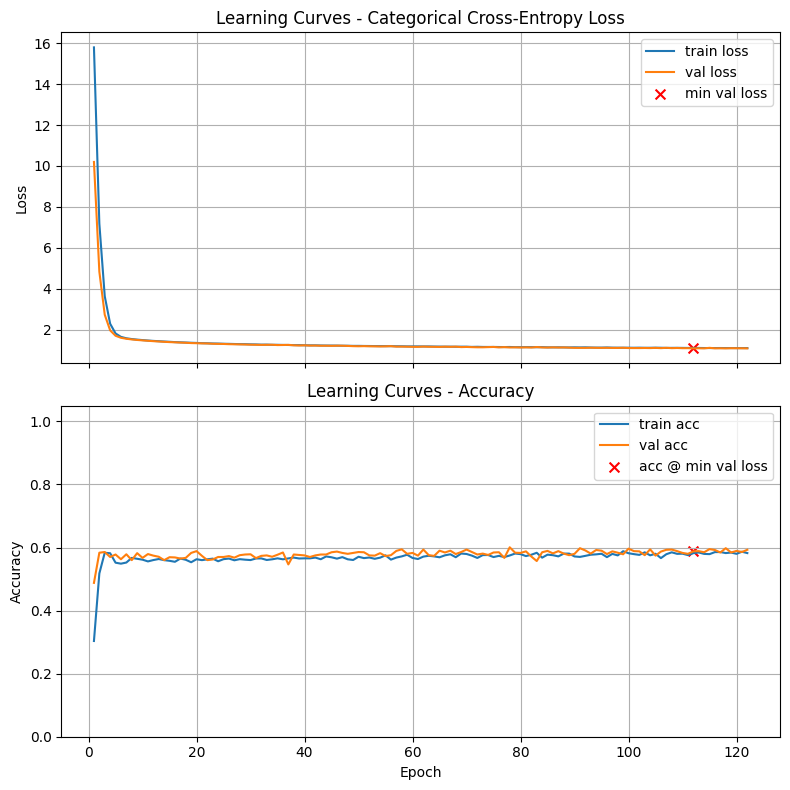

Final Training Loss:            1.1032
Final Training Accuracy:        0.5824
Final Validation Loss:          1.0886
Final Validation Accuracy:      0.5929
Minimum Validation Loss:        1.0884 (Epoch 112)
Validation Accuracy @ Min Loss: 0.5879

Test Loss: 1.1126
Test Accuracy: 0.5836

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:00:17
drop1=0.2, drop2=0.2 | best_epoch=111 | best_val_acc=0.587857

Learning Curves



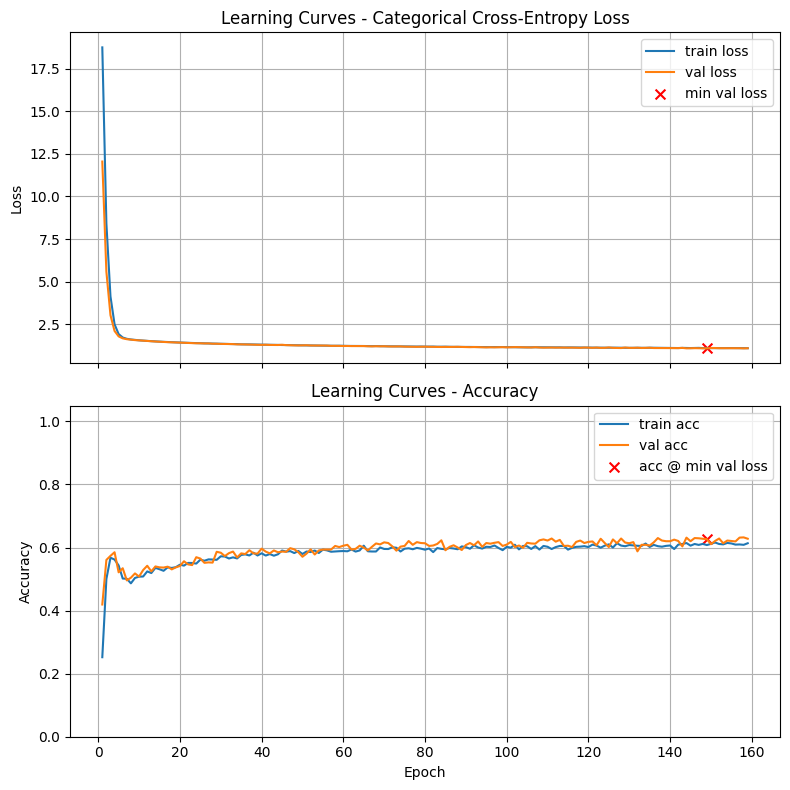

Final Training Loss:            1.1018
Final Training Accuracy:        0.6136
Final Validation Loss:          1.1001
Final Validation Accuracy:      0.6279
Minimum Validation Loss:        1.0910 (Epoch 149)
Validation Accuracy @ Min Loss: 0.6264

Test Loss: 1.1066
Test Accuracy: 0.6143

Validation-Test Gap (accuracy): 0.012143

Execution Time: 00:00:22
drop1=0.2, drop2=0.3 | best_epoch=148 | best_val_acc=0.626429

Learning Curves



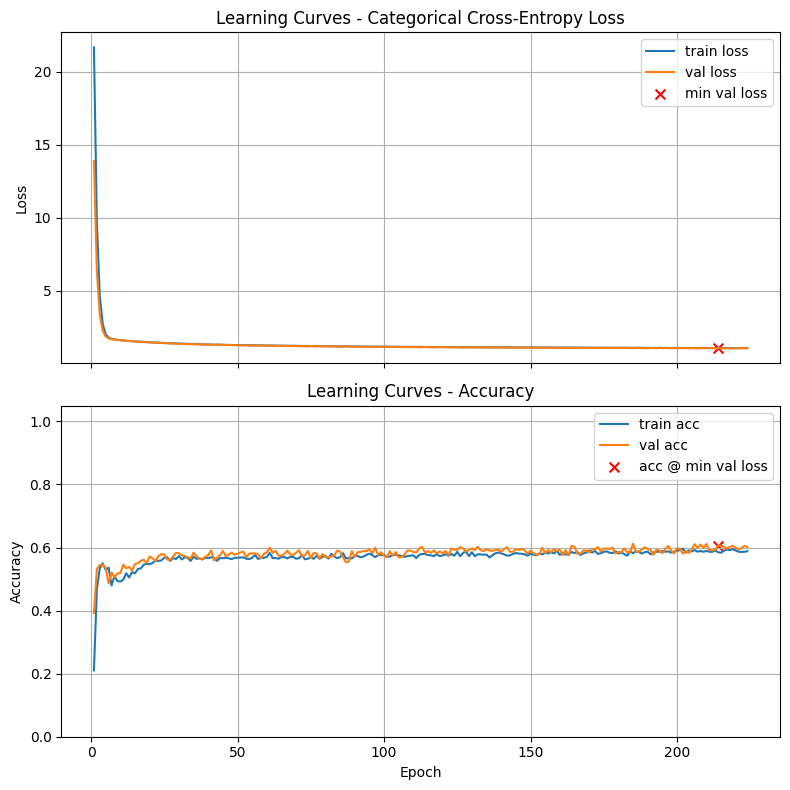

Final Training Loss:            1.0744
Final Training Accuracy:        0.5883
Final Validation Loss:          1.0584
Final Validation Accuracy:      0.6021
Minimum Validation Loss:        1.0541 (Epoch 214)
Validation Accuracy @ Min Loss: 0.6057

Test Loss: 1.0791
Test Accuracy: 0.5929

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:30
drop1=0.2, drop2=0.4 | best_epoch=213 | best_val_acc=0.605714

Learning Curves



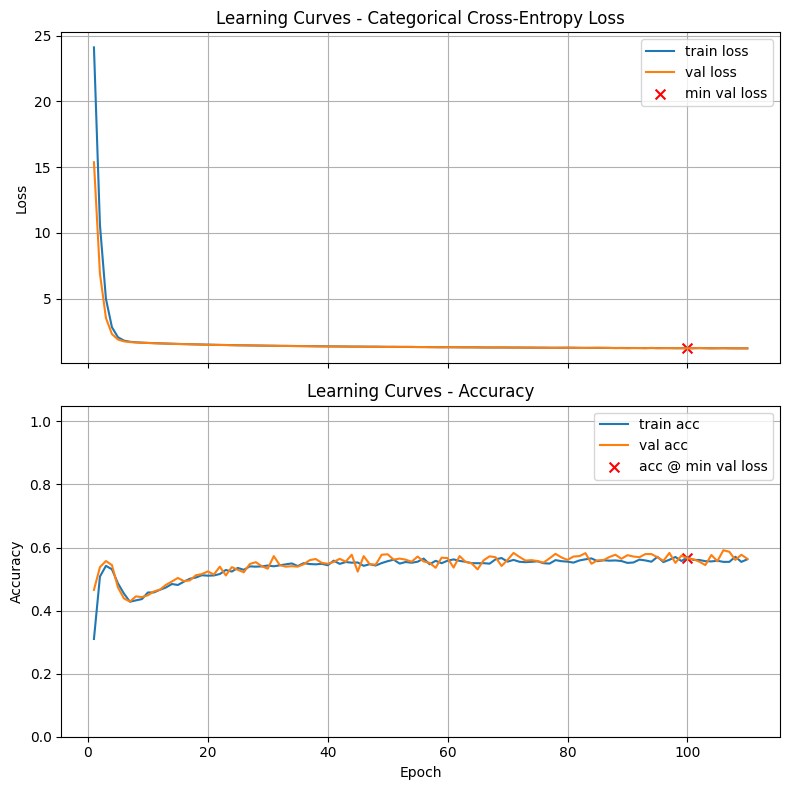

Final Training Loss:            1.2090
Final Training Accuracy:        0.5626
Final Validation Loss:          1.2128
Final Validation Accuracy:      0.5643
Minimum Validation Loss:        1.2074 (Epoch 100)
Validation Accuracy @ Min Loss: 0.5657

Test Loss: 1.2254
Test Accuracy: 0.5493

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:15
drop1=0.2, drop2=0.5 | best_epoch= 99 | best_val_acc=0.565714

BEST dropout config (drop1, drop2): (0.0, 0.2) best_val_acc: 0.7778571248054504


In [61]:
# Your code here. Add as many cells as you need. 
# =========================
# HW03 — Problem 3: Dropout sweep
# Uses: best_activation (Problem 1) and best_lr (Problem 2)
# Sweep dropout on layer1 (0.0–0.2) and layer2 (0.0–0.5) in steps of 0.1
# Select by validation accuracy at epoch of MIN validation loss
# =========================

import numpy as np
import tensorflow as tf

act = best_activation   # from Problem 1
lr  = a2a               # best learning rate from Problem 2 (or use best_lr if you stored it)

n_inputs  = X_train.shape[1]
n_classes = len(np.unique(y_train))

drop1_vals = [0.0, 0.1, 0.2]
drop2_vals = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

p3_histories = {}
p3_best_val_acc = {}

for d1 in drop1_vals:
    for d2 in drop2_vals:
        layer_list = [
            (64, act, d1, 0.0),   # (width, activation, dropout, lambda)
            (32, act, d2, 0.0),
        ]

        model_do = build_model(n_inputs, layer_list, n_classes)

        # compile with chosen best LR
        model_do.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
        )

        out = train_and_test(model_do, return_history=True, verbose=0) \
              if "return_history" in train_and_test.__code__.co_varnames else train_and_test(model_do)

        history = out[0] if isinstance(out, tuple) else out

        best_epoch = int(np.argmin(history.history["val_loss"]))
        best_val_acc = float(history.history["val_accuracy"][best_epoch])

        key = (d1, d2)
        p3_histories[key] = history
        p3_best_val_acc[key] = best_val_acc

        print(f"drop1={d1:.1f}, drop2={d2:.1f} | best_epoch={best_epoch:3d} | best_val_acc={best_val_acc:.6f}")

best_dropout_cfg = max(p3_best_val_acc, key=p3_best_val_acc.get)
print("\nBEST dropout config (drop1, drop2):", best_dropout_cfg,
      "best_val_acc:", p3_best_val_acc[best_dropout_cfg])

# If you want to visualize the best run:
# plot_history(p3_histories[best_dropout_cfg])


In [62]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = max(p3_best_val_acc, key=p3_best_val_acc.get)


In [63]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.0, 0.2)


In [64]:
# Set a3b to the validation accuracy found by this best pair of dropout rates
a3b = p3_best_val_acc[a3a]


In [65]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7779


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Learning Curves



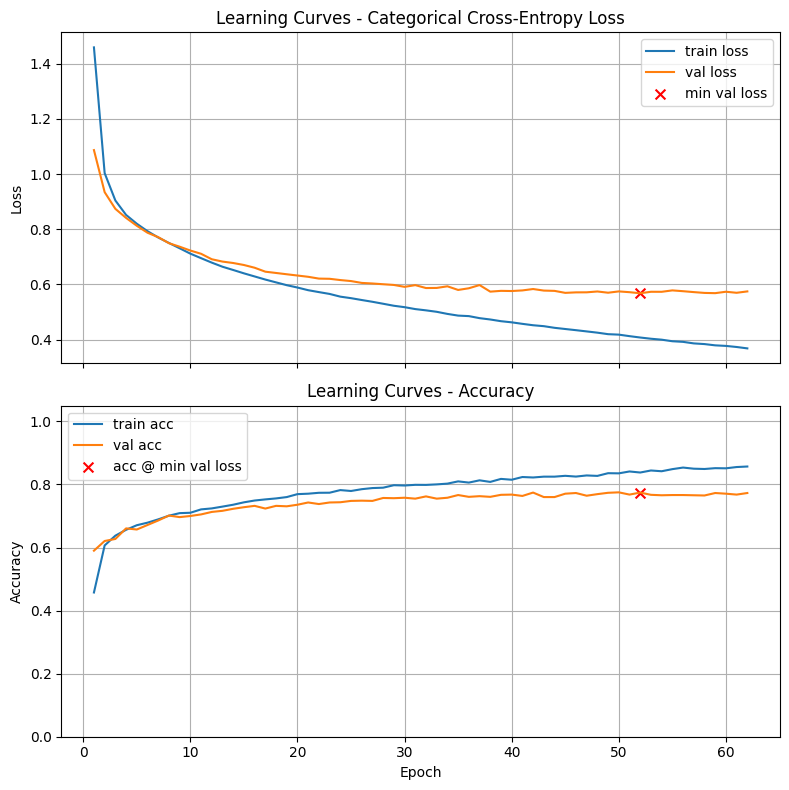

Final Training Loss:            0.3685
Final Training Accuracy:        0.8569
Final Validation Loss:          0.5749
Final Validation Accuracy:      0.7729
Minimum Validation Loss:        0.5682 (Epoch 52)
Validation Accuracy @ Min Loss: 0.7743

Test Loss: 0.5871
Test Accuracy: 0.7564

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:10
lam64=0.0001, lam32=0.0001 | best_epoch= 51 | best_val_acc=0.774286

Learning Curves



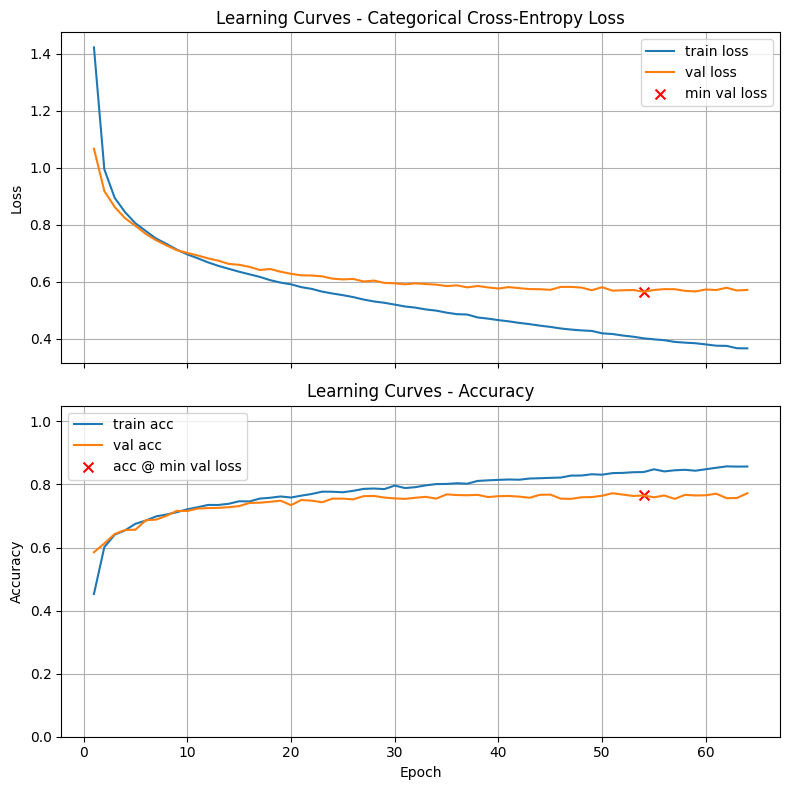

Final Training Loss:            0.3654
Final Training Accuracy:        0.8569
Final Validation Loss:          0.5708
Final Validation Accuracy:      0.7721
Minimum Validation Loss:        0.5645 (Epoch 54)
Validation Accuracy @ Min Loss: 0.7650

Test Loss: 0.5595
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.000714

Execution Time: 00:00:10
lam64=0.001, lam32=0.001 | best_epoch= 53 | best_val_acc=0.765000

Learning Curves



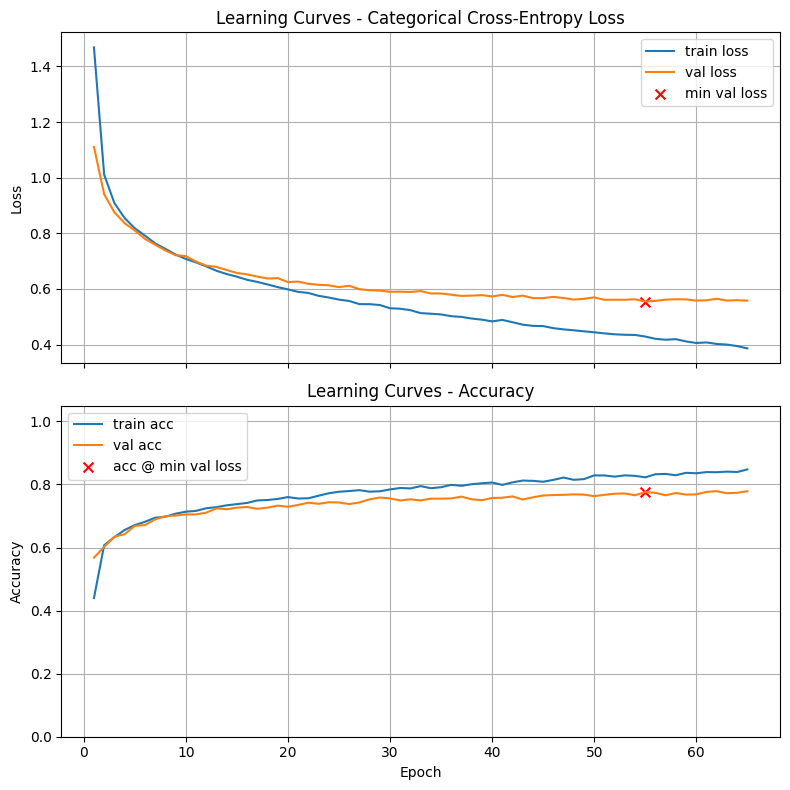

Final Training Loss:            0.3864
Final Training Accuracy:        0.8476
Final Validation Loss:          0.5581
Final Validation Accuracy:      0.7786
Minimum Validation Loss:        0.5547 (Epoch 55)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.5708
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.020714

Execution Time: 00:00:10
lam64=0.01, lam32=0.01 | best_epoch= 54 | best_val_acc=0.775714

Learning Curves



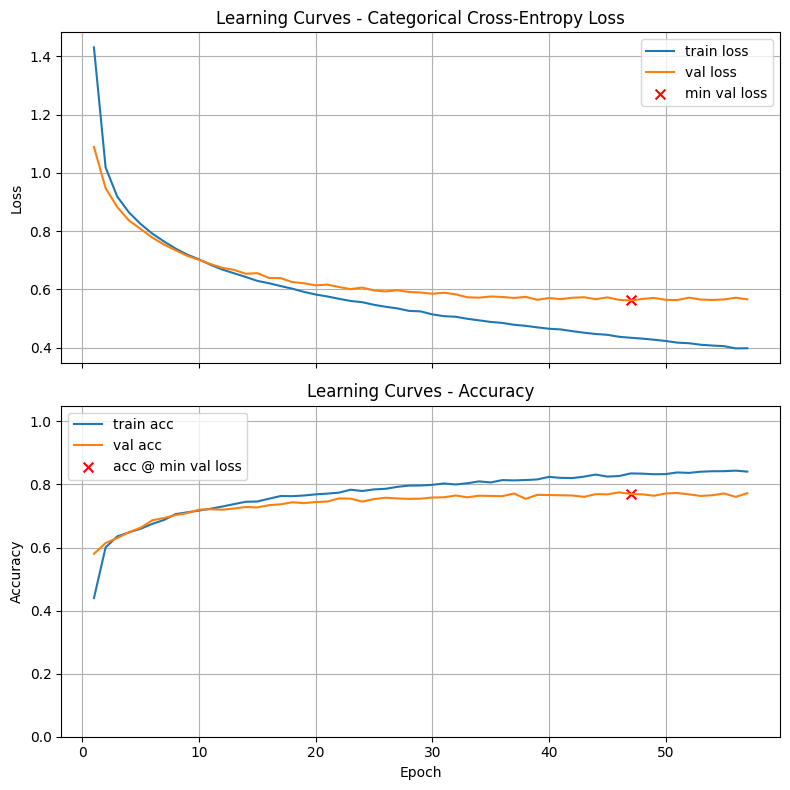

Final Training Loss:            0.3975
Final Training Accuracy:        0.8407
Final Validation Loss:          0.5656
Final Validation Accuracy:      0.7721
Minimum Validation Loss:        0.5617 (Epoch 47)
Validation Accuracy @ Min Loss: 0.7700

Test Loss: 0.5720
Test Accuracy: 0.7629

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:09
lam64=0.0001, lam32=0.001 | best_epoch= 46 | best_val_acc=0.770000

BEST L2 config (lam64, lam32): (0.01, 0.01) best_val_acc: 0.7757142782211304


In [66]:
# Your code here. Add as many cells as you need. 
# =========================
# HW03 — Problem 4: L2 (weight decay) sweep
# Uses: best_activation (Problem 1) and best LR (Problem 2)
# No dropout in this problem.
# Try: same lambda in both layers: 1e-4, 1e-3, 1e-2
# Plus at least one mixed case: (1e-4, 1e-3)
# Select by validation accuracy at epoch of MIN val_loss
# =========================

import numpy as np
import tensorflow as tf

act = best_activation
lr  = a2a  # best lr from Problem 2 (or use best_lr variable if you stored it)

n_inputs  = X_train.shape[1]
n_classes = len(np.unique(y_train))

# (lam64, lam32) pairs to test
lam_pairs = [
    (1e-4, 1e-4),
    (1e-3, 1e-3),
    (1e-2, 1e-2),
    (1e-4, 1e-3),   # mixed example
    # add more if you want, e.g. (1e-3, 1e-4)
]

p4_histories = {}
p4_best_val_acc = {}

for lam64, lam32 in lam_pairs:
    layer_list = [
        (64, act, 0.0, lam64),
        (32, act, 0.0, lam32),
    ]

    model_l2 = build_model(n_inputs, layer_list, n_classes)

    model_l2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    out = train_and_test(model_l2, return_history=True, verbose=0) \
          if "return_history" in train_and_test.__code__.co_varnames else train_and_test(model_l2)

    history = out[0] if isinstance(out, tuple) else out

    best_epoch = int(np.argmin(history.history["val_loss"]))
    best_val_acc = float(history.history["val_accuracy"][best_epoch])

    key = (lam64, lam32)
    p4_histories[key] = history
    p4_best_val_acc[key] = best_val_acc

    print(f"lam64={lam64:g}, lam32={lam32:g} | best_epoch={best_epoch:3d} | best_val_acc={best_val_acc:.6f}")

best_l2_cfg = max(p4_best_val_acc, key=p4_best_val_acc.get)
print("\nBEST L2 config (lam64, lam32):", best_l2_cfg,
      "best_val_acc:", p4_best_val_acc[best_l2_cfg])

# To visualize best:
# plot_history(p4_histories[best_l2_cfg])


In [67]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = max(p4_best_val_acc, key=p4_best_val_acc.get)


In [68]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.01, 0.01)


In [69]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = p4_best_val_acc[a4a]


In [70]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7757


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




Learning Curves



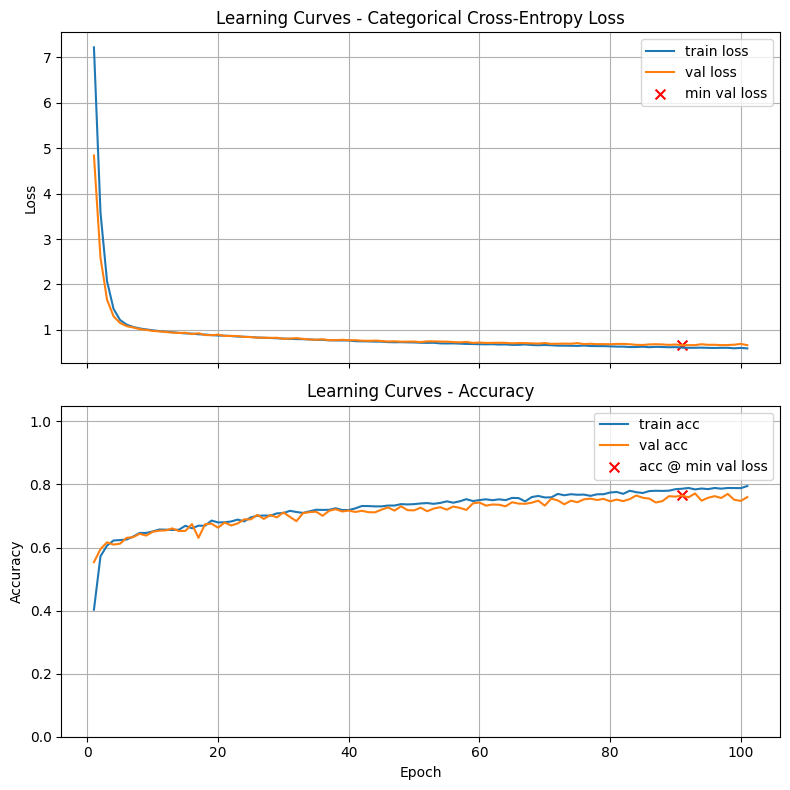

Final Training Loss:            0.5934
Final Training Accuracy:        0.7950
Final Validation Loss:          0.6643
Final Validation Accuracy:      0.7600
Minimum Validation Loss:        0.6632 (Epoch 91)
Validation Accuracy @ Min Loss: 0.7650

Test Loss: 0.6860
Test Accuracy: 0.7414

Validation-Test Gap (accuracy): 0.023571

Execution Time: 00:00:15
d64=0.0, d32=0.2, lam64=0.0001, lam32=0.0001 | best_epoch= 90 | best_val_acc=0.765000

Learning Curves



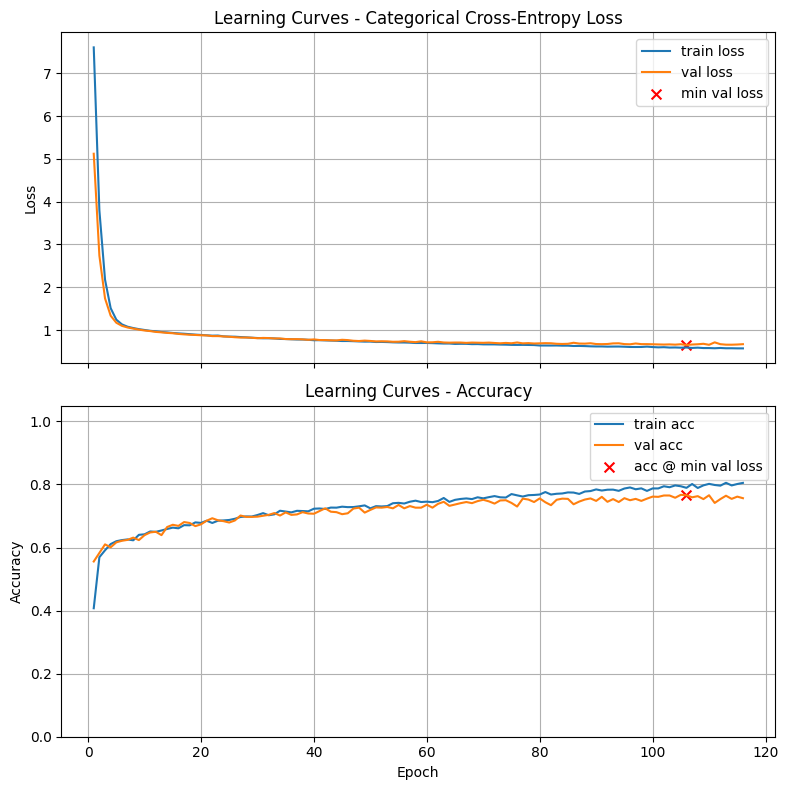

Final Training Loss:            0.5724
Final Training Accuracy:        0.8050
Final Validation Loss:          0.6705
Final Validation Accuracy:      0.7564
Minimum Validation Loss:        0.6520 (Epoch 106)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.6716
Test Accuracy: 0.7414

Validation-Test Gap (accuracy): 0.024286

Execution Time: 00:00:17
d64=0.0, d32=0.2, lam64=0.001, lam32=0.001 | best_epoch=105 | best_val_acc=0.765714

Learning Curves



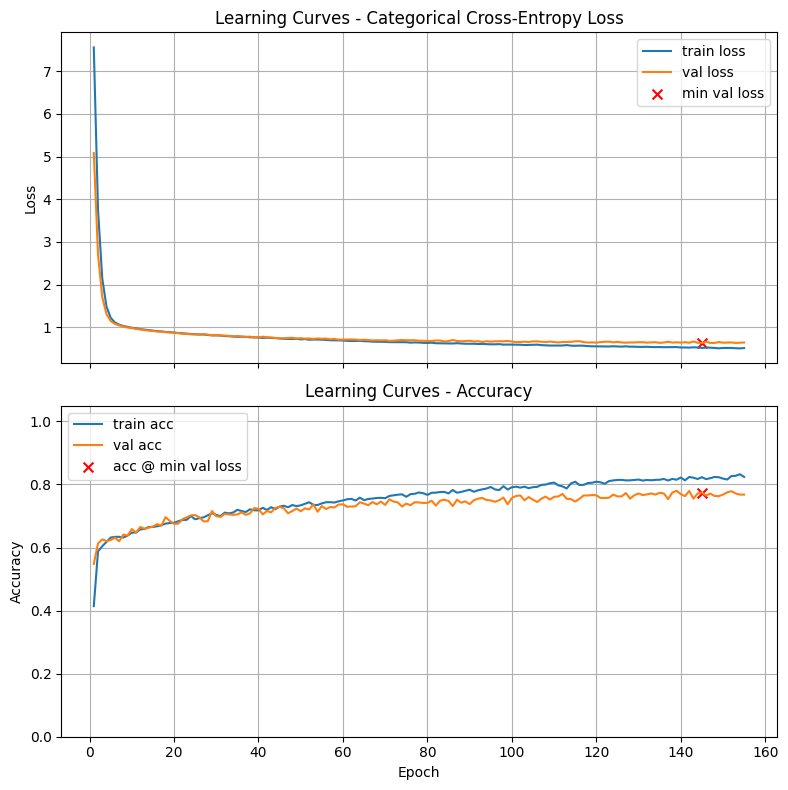

Final Training Loss:            0.5169
Final Training Accuracy:        0.8238
Final Validation Loss:          0.6475
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.6328 (Epoch 145)
Validation Accuracy @ Min Loss: 0.7743

Test Loss: 0.6694
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.021429

Execution Time: 00:00:22
d64=0.0, d32=0.2, lam64=0.01, lam32=0.01 | best_epoch=144 | best_val_acc=0.774286

Learning Curves



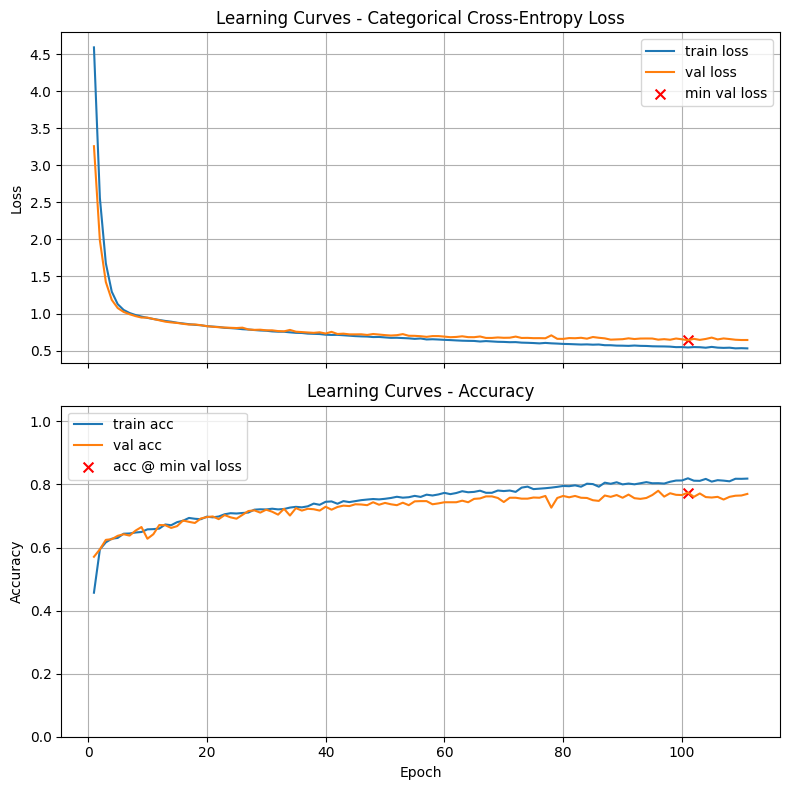

Final Training Loss:            0.5296
Final Training Accuracy:        0.8186
Final Validation Loss:          0.6428
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.6398 (Epoch 101)
Validation Accuracy @ Min Loss: 0.7743

Test Loss: 0.6690
Test Accuracy: 0.7507

Validation-Test Gap (accuracy): 0.023571

Execution Time: 00:00:16
d64=0.0, d32=0.1, lam64=0.0001, lam32=0.0001 | best_epoch=100 | best_val_acc=0.774286

Learning Curves



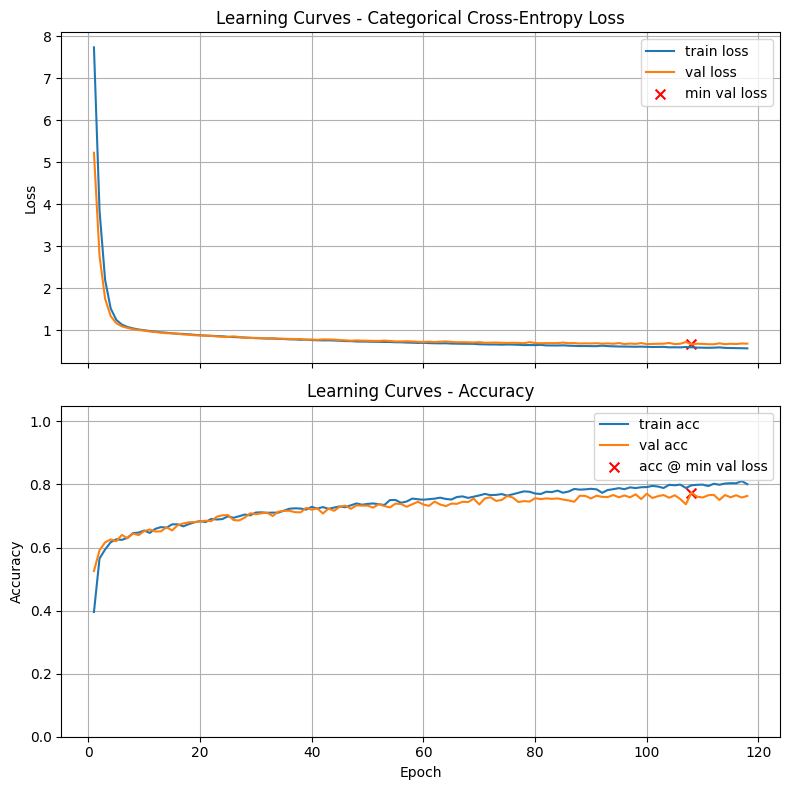

Final Training Loss:            0.5622
Final Training Accuracy:        0.8007
Final Validation Loss:          0.6751
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.6598 (Epoch 108)
Validation Accuracy @ Min Loss: 0.7743

Test Loss: 0.6727
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.020000

Execution Time: 00:00:18
d64=0.0, d32=0.2, lam64=0.0001, lam32=0.0001 | best_epoch=107 | best_val_acc=0.774286

Learning Curves



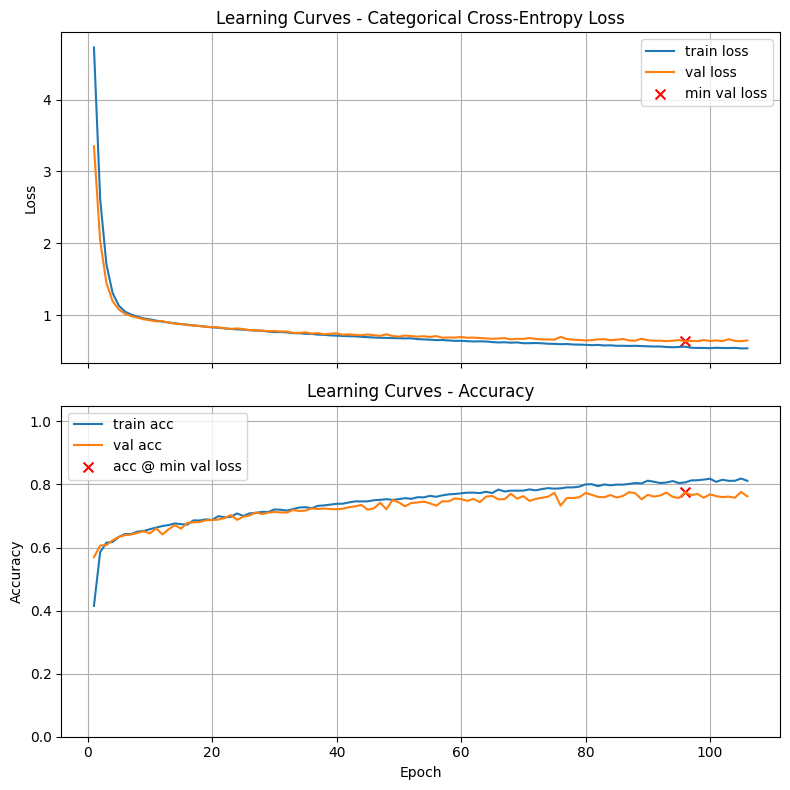

Final Training Loss:            0.5384
Final Training Accuracy:        0.8114
Final Validation Loss:          0.6484
Final Validation Accuracy:      0.7621
Minimum Validation Loss:        0.6364 (Epoch 96)
Validation Accuracy @ Min Loss: 0.7750

Test Loss: 0.6650
Test Accuracy: 0.7486

Validation-Test Gap (accuracy): 0.026429

Execution Time: 00:00:16
d64=0.0, d32=0.1, lam64=0.0001, lam32=0.0001 | best_epoch= 95 | best_val_acc=0.775000

Learning Curves



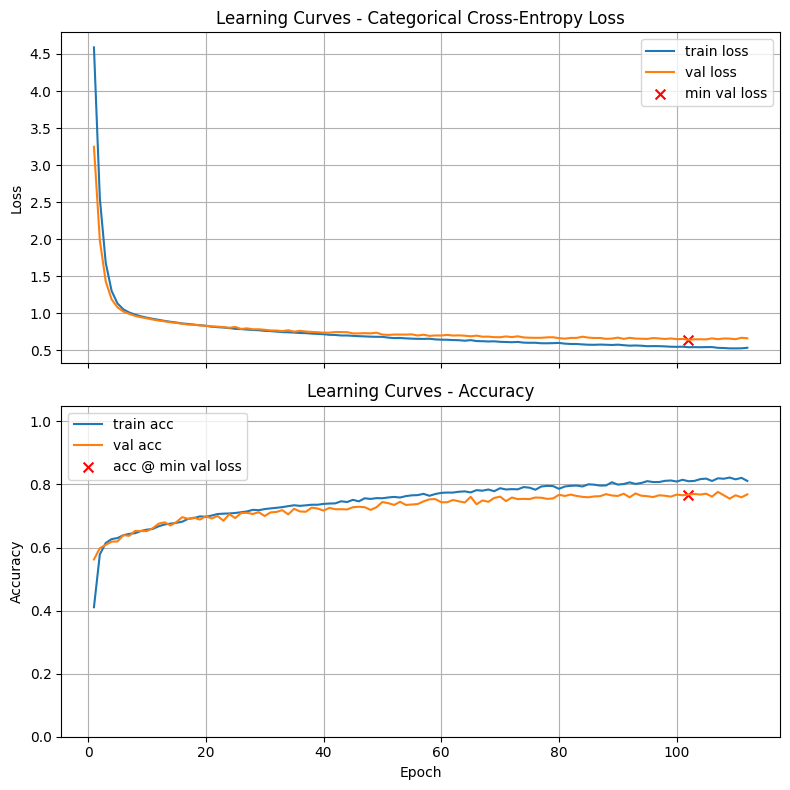

Final Training Loss:            0.5346
Final Training Accuracy:        0.8112
Final Validation Loss:          0.6624
Final Validation Accuracy:      0.7686
Minimum Validation Loss:        0.6427 (Epoch 102)
Validation Accuracy @ Min Loss: 0.7679

Test Loss: 0.6491
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:16
d64=0.0, d32=0.1, lam64=0.001, lam32=0.001 | best_epoch=101 | best_val_acc=0.767857

Learning Curves



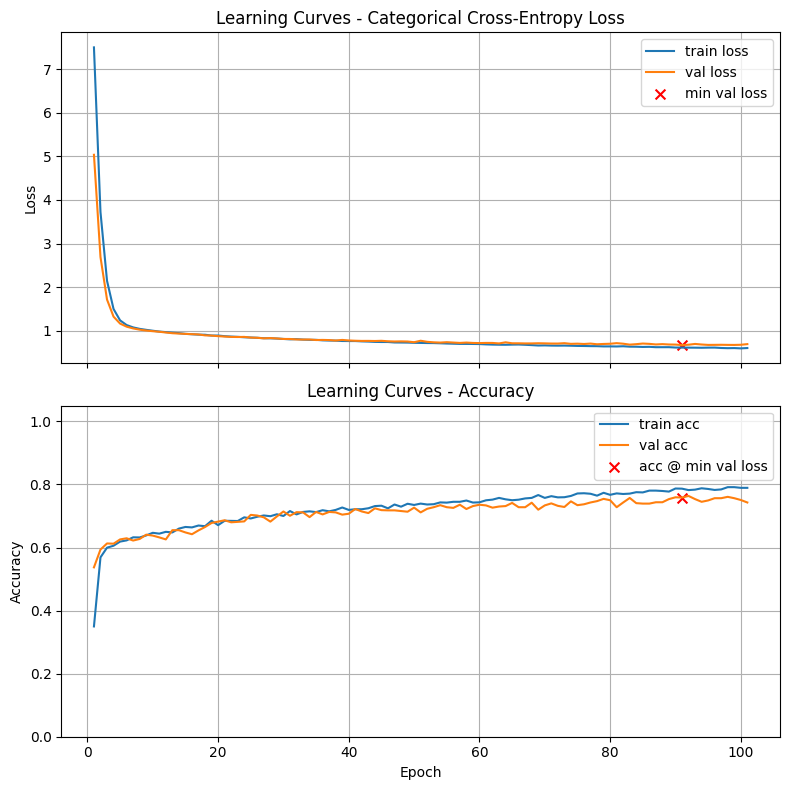

Final Training Loss:            0.6050
Final Training Accuracy:        0.7893
Final Validation Loss:          0.6945
Final Validation Accuracy:      0.7429
Minimum Validation Loss:        0.6724 (Epoch 91)
Validation Accuracy @ Min Loss: 0.7586

Test Loss: 0.6865
Test Accuracy: 0.7436

Validation-Test Gap (accuracy): 0.015000

Execution Time: 00:00:15
d64=0.0, d32=0.2, lam64=0.001, lam32=0.001 | best_epoch= 90 | best_val_acc=0.758571

Learning Curves



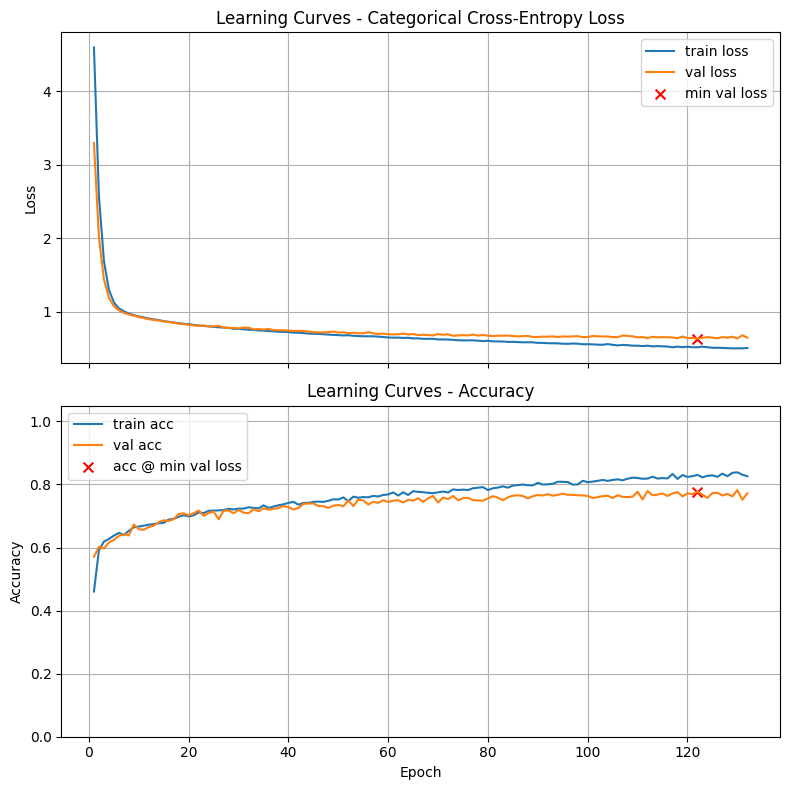

Final Training Loss:            0.5025
Final Training Accuracy:        0.8260
Final Validation Loss:          0.6441
Final Validation Accuracy:      0.7721
Minimum Validation Loss:        0.6316 (Epoch 122)
Validation Accuracy @ Min Loss: 0.7771

Test Loss: 0.6463
Test Accuracy: 0.7643

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:19
d64=0.0, d32=0.1, lam64=0.001, lam32=0.001 | best_epoch=121 | best_val_acc=0.777143

Learning Curves



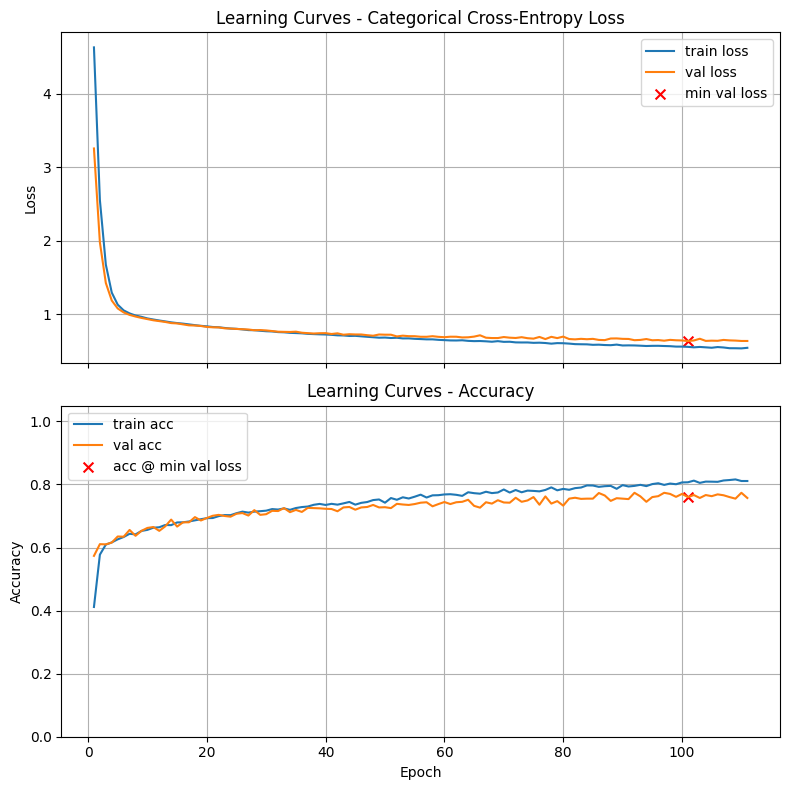

Final Training Loss:            0.5415
Final Training Accuracy:        0.8110
Final Validation Loss:          0.6347
Final Validation Accuracy:      0.7571
Minimum Validation Loss:        0.6337 (Epoch 101)
Validation Accuracy @ Min Loss: 0.7600

Test Loss: 0.6594
Test Accuracy: 0.7507

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:16
d64=0.0, d32=0.1, lam64=0.01, lam32=0.01 | best_epoch=100 | best_val_acc=0.760000

Learning Curves



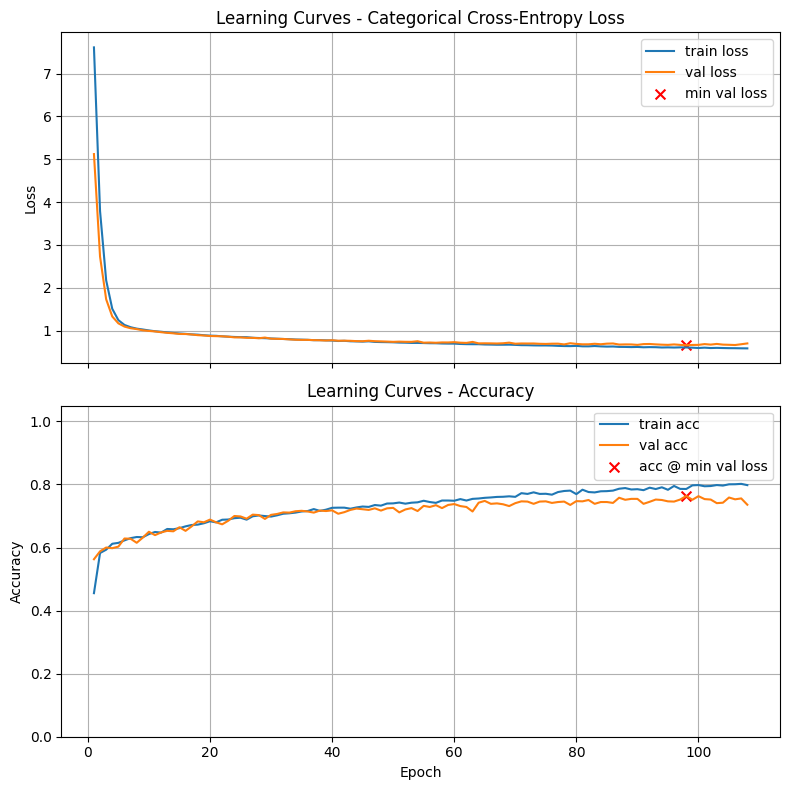

Final Training Loss:            0.5829
Final Training Accuracy:        0.7979
Final Validation Loss:          0.6988
Final Validation Accuracy:      0.7357
Minimum Validation Loss:        0.6571 (Epoch 98)
Validation Accuracy @ Min Loss: 0.7636

Test Loss: 0.6867
Test Accuracy: 0.7479

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:16
d64=0.0, d32=0.2, lam64=0.01, lam32=0.01 | best_epoch= 97 | best_val_acc=0.763571

Learning Curves



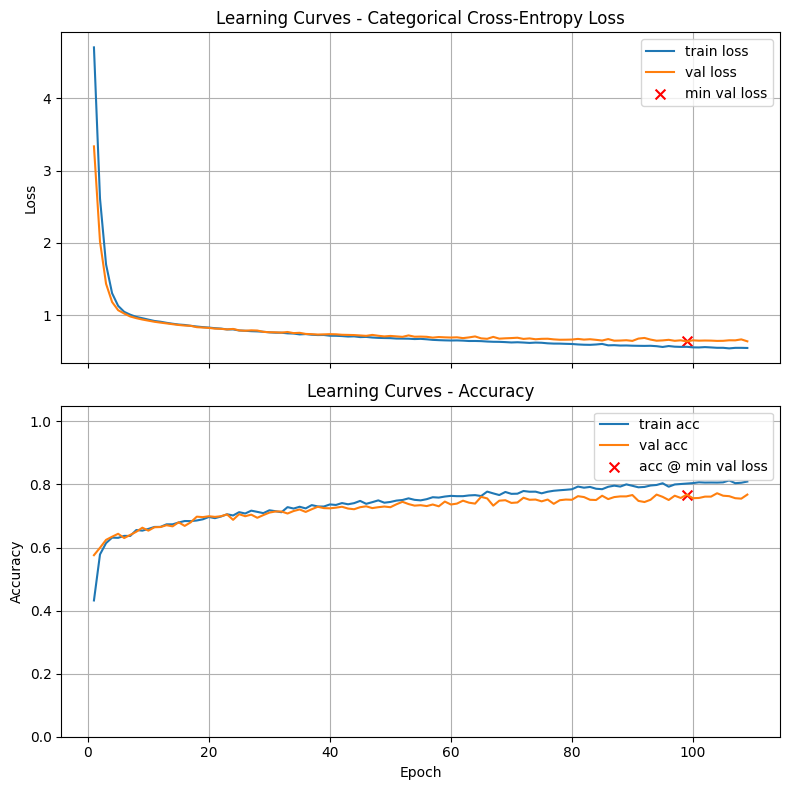

Final Training Loss:            0.5505
Final Training Accuracy:        0.8093
Final Validation Loss:          0.6423
Final Validation Accuracy:      0.7679
Minimum Validation Loss:        0.6404 (Epoch 99)
Validation Accuracy @ Min Loss: 0.7679

Test Loss: 0.6638
Test Accuracy: 0.7629

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:00:16
d64=0.0, d32=0.1, lam64=0.01, lam32=0.01 | best_epoch= 98 | best_val_acc=0.767857

BEST combo (d64,d32,lam64,lam32): (0.0, 0.1, 0.001, 0.001) best_val_acc: 0.7771428823471069


In [71]:
# Your code here. Add as many cells as you need.
# =========================
# HW03 — Problem 5: Combine Dropout + L2
# Uses: best_activation (P1), best lr (P2), best dropout pair (P3)
# 1) Fix dropout at best pair from P3, sweep L2 in [1e-4, 1e-3, 1e-2] applied to BOTH layers
# 2) Then reduce dropout slightly when L2 is added (simple heuristic)
# Select by validation accuracy at epoch of MIN val_loss
# =========================

import numpy as np
import tensorflow as tf

act = best_activation
lr  = a2a                 # best lr from Problem 2
drop_best = a3a           # (drop64, drop32) from Problem 3
drop64_base, drop32_base = drop_best

n_inputs  = X_train.shape[1]
n_classes = len(np.unique(y_train))

l2_vals = [1e-4, 1e-3, 1e-2]

# Build a list of (drop64, drop32, lam64, lam32) configs to try
configs = []

# A) Keep dropout fixed, add same L2 to both layers
for lam in l2_vals:
    configs.append((drop64_base, drop32_base, lam, lam))

# B) Reduce dropout slightly with L2 (clamp at >=0)
def clamp01(x): 
    return float(max(0.0, min(1.0, x)))

reduced_pairs = [
    (clamp01(drop64_base - 0.1), clamp01(drop32_base - 0.1)),
    (clamp01(drop64_base - 0.1), drop32_base),
    (drop64_base, clamp01(drop32_base - 0.1)),
]

for lam in l2_vals:
    for d64, d32 in reduced_pairs:
        configs.append((d64, d32, lam, lam))

# (Optional) you can add a mixed-lambda variant too:
# configs.append((drop64_base, drop32_base, 1e-4, 1e-3))

p5_histories = {}
p5_best_val_acc = {}

for d64, d32, lam64, lam32 in configs:
    layer_list = [
        (64, act, d64, lam64),
        (32, act, d32, lam32),
    ]

    model_combo = build_model(n_inputs, layer_list, n_classes)

    model_combo.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    out = train_and_test(model_combo, return_history=True, verbose=0) \
          if "return_history" in train_and_test.__code__.co_varnames else train_and_test(model_combo)

    history = out[0] if isinstance(out, tuple) else out

    best_epoch = int(np.argmin(history.history["val_loss"]))
    best_val_acc = float(history.history["val_accuracy"][best_epoch])

    key = (d64, d32, lam64, lam32)
    p5_histories[key] = history
    p5_best_val_acc[key] = best_val_acc

    print(f"d64={d64:.1f}, d32={d32:.1f}, lam64={lam64:g}, lam32={lam32:g} | "
          f"best_epoch={best_epoch:3d} | best_val_acc={best_val_acc:.6f}")

best_combo = max(p5_best_val_acc, key=p5_best_val_acc.get)
print("\nBEST combo (d64,d32,lam64,lam32):", best_combo,
      "best_val_acc:", p5_best_val_acc[best_combo])

# To visualize best:
# plot_history(p5_histories[best_combo])


In [72]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = p5_best_val_acc[best_combo]


In [73]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.7771


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.


In [74]:
# Your code here
# =========================
# Problem 6: Build + Train "Best" Model (template you can tweak)
# Uses early stopping and reports val_accuracy at the epoch of MIN val_loss.
# Assumes you already have: X_train, y_train, X_val, y_val
# (and they’re already standardized if needed).
# =========================

import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay, CosineDecay

# ---- dataset dims ----
n_inputs  = X_train.shape[1]
n_classes = len(np.unique(y_train))

# =========================
# 1) Choose your hyperparameters here
# =========================
BATCH_SIZE = 64
MAX_EPOCHS = 800

# Architecture (example: deeper than baseline, still dense-only)
WIDTHS = [128, 64, 32]

ACTIVATION = "relu"

# Regularization
DROPOUTS = [0.10, 0.20, 0.30]     # same length as WIDTHS (or use 0.0 for none)
L2_LAMS  = [1e-4, 1e-4, 1e-4]     # same length as WIDTHS (or 0.0 for none)

# Learning rate: pick ONE option below

# Option A) Constant LR
USE_SCHEDULE = False
LR = 5e-4

# Option B) Exponential Decay (uncomment to use)
# USE_SCHEDULE = True
# steps_per_epoch = int(np.ceil(len(X_train) / BATCH_SIZE))
# lr_schedule = ExponentialDecay(
#     initial_learning_rate=5e-4,
#     decay_steps=steps_per_epoch * 10,
#     decay_rate=0.95,
#     staircase=False
# )

# Option C) Cosine Decay (uncomment to use)
# USE_SCHEDULE = True
# steps_per_epoch = int(np.ceil(len(X_train) / BATCH_SIZE))
# lr_schedule = CosineDecay(
#     initial_learning_rate=5e-4,
#     decay_steps=steps_per_epoch * 20
# )

# =========================
# 2) Build model
# =========================
def build_best_model():
    model = Sequential()
    model.add(Input(shape=(n_inputs,)))

    for w, dr, lam in zip(WIDTHS, DROPOUTS, L2_LAMS):
        reg = l2(lam) if lam and lam > 0 else None
        model.add(Dense(w, activation=ACTIVATION, kernel_regularizer=reg))
        if dr and dr > 0:
            model.add(Dropout(dr))

    model.add(Dense(n_classes, activation="softmax"))
    return model

model_best = build_best_model()
model_best.summary()

# =========================
# 3) Compile
# =========================
optimizer = Adam(learning_rate=lr_schedule) if USE_SCHEDULE else Adam(learning_rate=LR)

model_best.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# =========================
# 4) Train with Early Stopping (min val_loss)
# =========================
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=20,
    min_delta=1e-4,
    restore_best_weights=True
)

history_best = model_best.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

# Optional: plot curves if you have plot_history(history)
# plot_history(history_best)

# =========================
# 5) Report validation accuracy at epoch of MIN val_loss (graded metric)
# =========================
best_epoch = int(np.argmin(history_best.history["val_loss"]))
best_val_acc = float(history_best.history["val_accuracy"][best_epoch])
print("Best epoch (min val_loss):", best_epoch)
print("Validation accuracy at best epoch:", best_val_acc)

# If your graded variable is named a6:
a6 = best_val_acc
a6


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_135 (Dense)               │ (None, 128)            │         7,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_136 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_137 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,607 (68.78 KB)

 Trainable params: 17,607 (68.78 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/800
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2626 - loss: 1.8764 - val_accuracy: 0.4686 - val_loss: 1.6423
Epoch 2/800
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4233 - loss: 1.5913 - val_accuracy: 0.5600 - val_loss: 1.3191
Epoch 3/800
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5062 - loss: 1.3393 - val_accuracy: 0.5971 - val_loss: 1.0855
Epoch 4/800
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5400 - loss: 1.2118 - val_accuracy: 0.6236 - val_loss: 0.9821
Epoch 5/800
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5476 - loss: 1.1498 - val_accuracy: 0.6293 - val_loss: 0.9357
Epoch 6/800
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5814 - loss: 1.0749 - val_accuracy: 0.6379 - val_loss: 0.8975
Epoch 7/800
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5907 - loss: 1.0323 - val_accuracy: 0.6564 - val_loss: 0.8737
Epoch 8/800
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6071 - loss: 1.0064 - val_accuracy: 0.6600 - v

0.7907142639160156

In [75]:
# Set a6 to the validation accuracy found by this best model

a6 = best_val_acc


In [77]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.7907


### Optional: Print out your results of all experiments

In [78]:
print_results()

Problem 2 — lr=5e-05                    	0.7871
Problem 1 — Activation: tanh            	0.7843
Problem 2 — lr=0.0001                   	0.7807
Problem 1 — Activation: relu            	0.7800
Problem 2 — lr=0.001                    	0.7793
Problem 2 — lr=1e-05                    	0.7793
Problem 2 — lr=0.0005                   	0.7771
Learning Curves                         	0.7679
Problem 1 — Activation: sigmoid         	0.7664


## Reflection Questions (ungraded)

It would be a great idea to think through your answers to these questions, then give ChatGPT (or other AI tool) a PDF of your
homework, and **discuss** (not just ask) these. 

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?